# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import roc_auc_score
# magic word for producing visualizations in notebook
%matplotlib inline
pd.set_option('display.max_columns', 500)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.impute import SimpleImputer 


from pylab import rcParams

from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import itertools
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import pickle

from util import *

from pca import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from sklearn.utils import resample


from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from cluster import *

## Part 0: Get to Know the Data + EDA

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [85]:
# load in the data
customers = pd.read_csv('costumers_all.csv', sep=';')

/home/lexlabs/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [86]:
#reading azdias
azdias = pd.read_csv('azdias_all.csv', sep=';')

/home/lexlabs/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [87]:
#turning the process faster
azdias = azdias.sample(100000)
customers = customers.sample(50000)

In [88]:
#dictionary attributes
description = pd.read_csv('az_dias_description.csv', sep=';')

In [89]:
#function that print shape of dataframe
def print_shape_df(df,name):
    nrows, ncols = df.shape
    print(name)
    print("Number of rows: ",nrows)
    print("Number of features: ",ncols)

#print_shape_df(azdias,"AZDIAS")
#print_shape_df(customers,"CUSTOMERS")
#print_shape_df(description,"DESCRIPTION")

In [90]:
#Lets analyse the features
print(set(azdias.columns)-set(customers.columns))
print(set(customers.columns)-set(azdias.columns))
print(set(azdias.columns)-set(description["Attribute"].values))
print(set(description["Attribute"].values)-set(azdias.columns))
print(len(set(azdias.columns)-set(description["Attribute"].values)))
print(len(set(description["Attribute"].values)-set(azdias.columns)))


set()
{'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'}
{'CJT_TYP_1', 'CJT_TYP_3', 'AKT_DAT_KL', 'LNR', 'ANZ_KINDER', 'VERDICHTUNGSRAUM', 'D19_VERSICHERUNGEN', 'D19_BANKEN_DIREKT', 'D19_VERSI_ONLINE_QUOTE_12', 'VHA', 'Unnamed: 0', 'D19_VERSI_ONLINE_DATUM', 'VHN', 'D19_SONSTIGE', 'EINGEZOGENAM_HH_JAHR', 'ALTER_KIND2', 'D19_HANDWERK', 'KK_KUNDENTYP', 'UMFELD_ALT', 'D19_DROGERIEARTIKEL', 'RT_UEBERGROESSE', 'D19_NAHRUNGSERGAENZUNG', 'DSL_FLAG', 'D19_BEKLEIDUNG_REST', 'D19_VERSI_OFFLINE_DATUM', 'D19_KONSUMTYP_MAX', 'KBA13_ANTG3', 'D19_TECHNIK', 'CJT_TYP_6', 'D19_TELKO_REST', 'D19_BIO_OEKO', 'D19_TELKO_MOBILE', 'UNGLEICHENN_FLAG', 'D19_BANKEN_LOKAL', 'D19_VOLLSORTIMENT', 'FIRMENDICHTE', 'CJT_KATALOGNUTZER', 'D19_TIERARTIKEL', 'D19_KOSMETIK', 'D19_ENERGIE', 'D19_VERSI_DATUM', 'D19_DIGIT_SERV', 'D19_BILDUNG', 'D19_LETZTER_KAUF_BRANCHE', 'D19_BEKLEIDUNG_GEH', 'KBA13_CCM_1401_2500', 'ANZ_STATISTISCHE_HAUSHALTE', 'VK_DISTANZ', 'D19_BANKEN_GROSS', 'D19_VERSAND_REST', 'VK_ZG11', 'KBA13_BAUMAX'

In [91]:
#preprocessing data
azdias = pre_processing(azdias)
customers = pre_processing(customers)
#print shape
print_shape_df(azdias,"AZDIAS")
print_shape_df(customers,"CUSTOMERS")


AZDIAS
Number of rows:  100000
Number of features:  365
CUSTOMERS
Number of rows:  50000
Number of features:  368


In [92]:
#pre processing customers
custumers = pre_processing_customers(customers)

**Let's see the number of empty values in dataset**

In [93]:
#funtion that calc Nan stats from dataframe
def calculate_nan_summary(df):
    resume_isna = df.isna().sum().reset_index()
    resume_isna.columns = ["feature","NAN (%)"]
    resume_isna = resume_isna.set_index("feature")
    total = len(df)
    resume_isna["NAN (%)"] = resume_isna["NAN (%)"]*100/total
    resume_isna["NAN (%)"] = resume_isna["NAN (%)"].apply(lambda x: round(x,3))
    return resume_isna

#funtion that flot Nan stats from dataframe
def plot_histogram_nan_values(df,title):
    plt.suptitle(title)
    df.hist(figsize=(12,8))    

#funtion that plot Nan stats from dataframe
def plot_bar_chart_high_nan_values(resume_isna,threshold):
        resume_isna[resume_isna["NAN (%)"]>=threshold].plot(kind='barh', figsize=(6,10),title="% NAN values")

In [94]:
#calculating nan stats
resume_isna_azdias = calculate_nan_summary(azdias)
resume_isna_costumers = calculate_nan_summary(customers)

<Figure size 432x288 with 0 Axes>

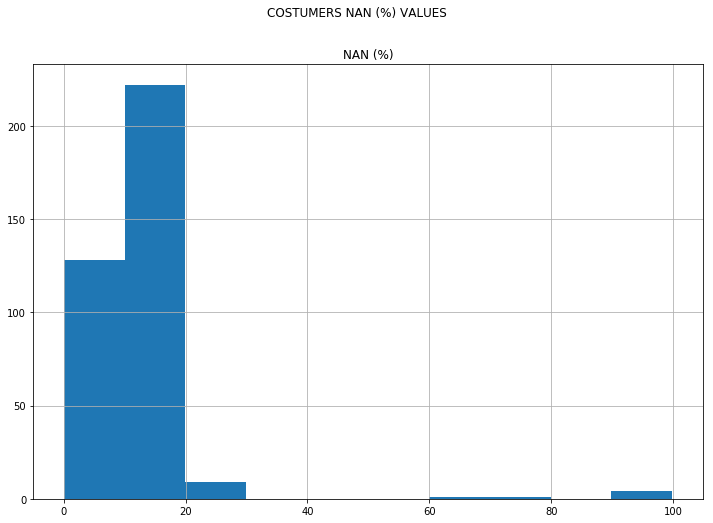

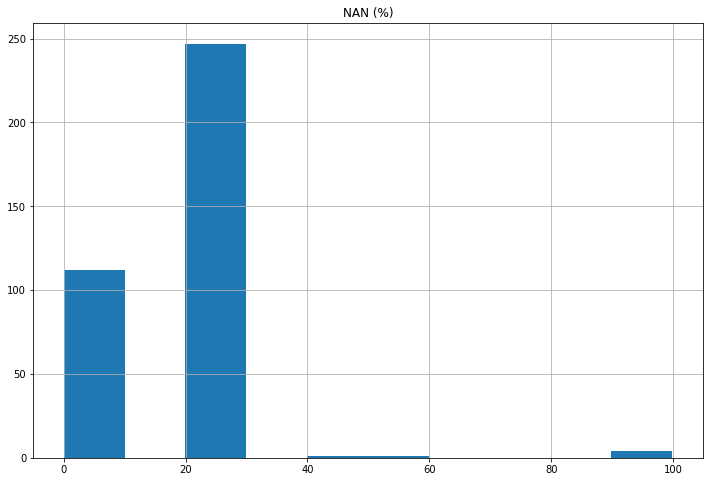

In [95]:
#ploting
plot_histogram_nan_values(resume_isna_azdias,"AZDIAS NAN (%) VALUES")
plot_histogram_nan_values(resume_isna_costumers,"COSTUMERS NAN (%) VALUES")

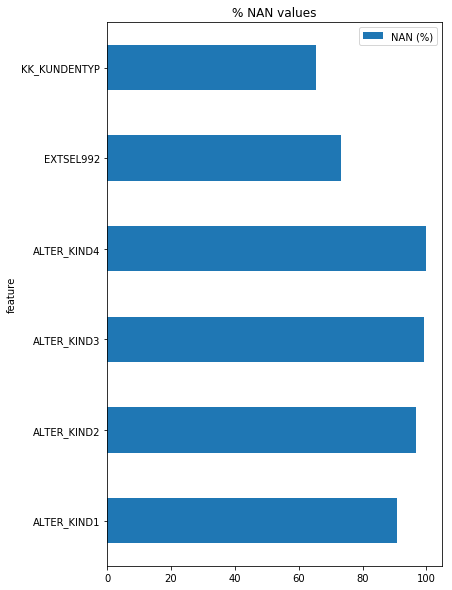

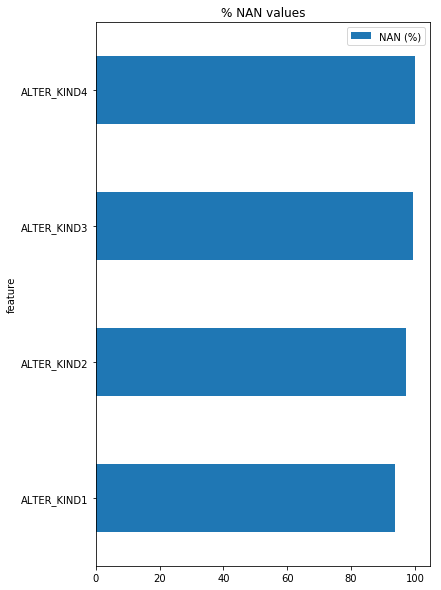

In [96]:
#ploting features with high NaN values
plot_bar_chart_high_nan_values(resume_isna_azdias,60)
plot_bar_chart_high_nan_values(resume_isna_costumers,60)

In [97]:
#map categorical values that represents unkonwn values
azdias_step1 = map_to_unkown(azdias)
customers_step1 = map_to_unkown(customers)

0  rows processed
1000  rows processed
2000  rows processed
3000  rows processed
4000  rows processed
5000  rows processed
6000  rows processed
7000  rows processed
8000  rows processed
9000  rows processed
10000  rows processed
11000  rows processed
12000  rows processed
13000  rows processed
14000  rows processed
15000  rows processed
16000  rows processed
17000  rows processed
18000  rows processed
19000  rows processed
20000  rows processed
21000  rows processed
22000  rows processed
23000  rows processed
24000  rows processed
25000  rows processed
26000  rows processed
27000  rows processed
28000  rows processed
29000  rows processed
30000  rows processed
31000  rows processed
32000  rows processed
33000  rows processed
34000  rows processed
35000  rows processed
36000  rows processed
37000  rows processed
38000  rows processed
39000  rows processed
40000  rows processed
41000  rows processed
42000  rows processed
43000  rows processed
44000  rows processed
45000  rows processed
4

In [ ]:
#creating, changing and trasnforming features
azdias_step1 = feature_eng(azdias_step1)
customers_step1 = feature_eng(customers_step1)

In [124]:
#calculating again NaN stats
resume_isna_azdias_step1 = calculate_nan_summary(azdias_step1)
resume_isna_costumers_step1 = calculate_nan_summary(customers_step1)

<Figure size 432x288 with 0 Axes>

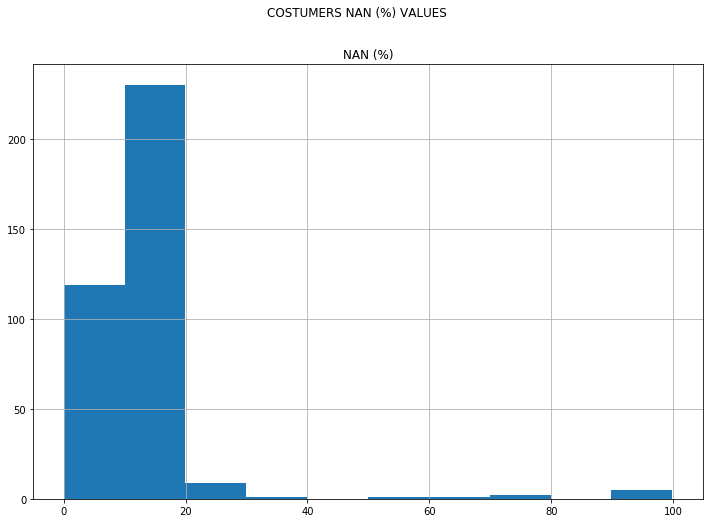

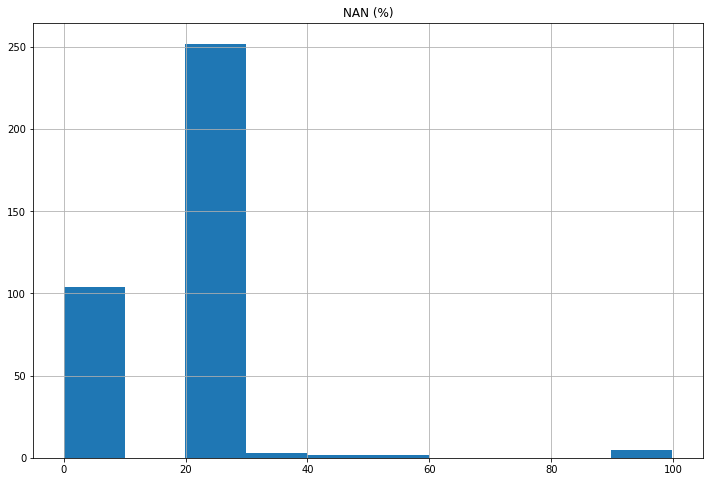

In [125]:
#ploting again NaN stats
plot_histogram_nan_values(resume_isna_azdias_step1,"AZDIAS NAN (%) VALUES")
plot_histogram_nan_values(resume_isna_costumers_step1,"COSTUMERS NAN (%) VALUES")

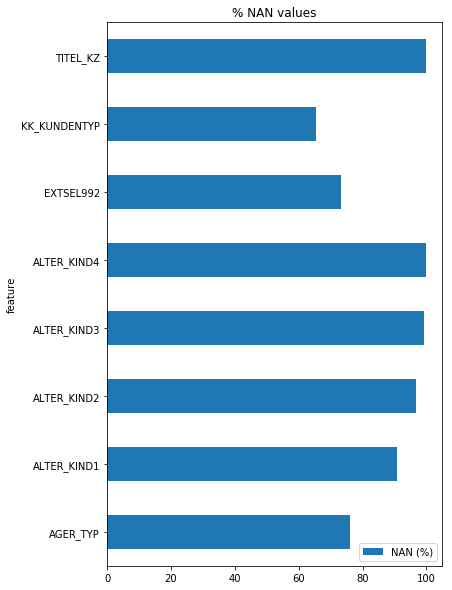

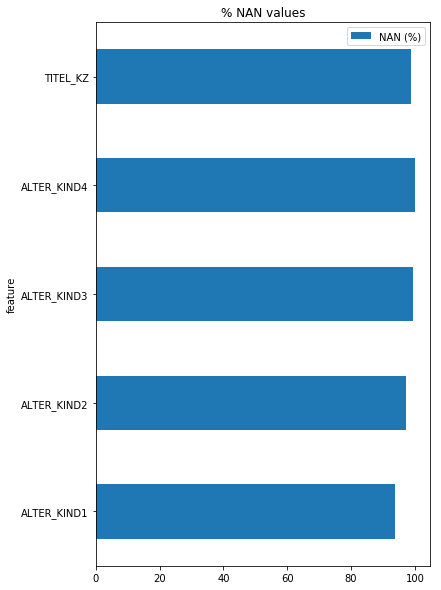

In [126]:
#ploting again features with high NaN ration
plot_bar_chart_high_nan_values(resume_isna_azdias_step1,60)
plot_bar_chart_high_nan_values(resume_isna_costumers_step1,60)

In [127]:
#dropping features with high NaN stats
def drop_high_missing_values_columns(df,resumed_isna,thresold=30):
    high_missing_values_features = list(resumed_isna[resumed_isna["NAN (%)"]>=thresold].index)
    return df.drop(columns=high_missing_values_features)

In [128]:
azdias_step2 = drop_high_missing_values_columns(azdias_step1,resume_isna_azdias_step1)
customers_step2 = drop_high_missing_values_columns(customers_step1,resume_isna_costumers_step1)

In [129]:
print_shape_df(azdias_step2,"AZDIAS")
print_shape_df(customers_step2,"COSTUMERS")

AZDIAS
Number of rows:  100000
Number of features:  358
COSTUMERS
Number of rows:  50000
Number of features:  356


In [130]:
#function that calculate NaN values in rows 
def calculate_missing_values_per_row(df):
    missing_values_per_row = df.isnull().transpose().sum().reset_index()
    missing_values_per_row.columns = ["line","Number of Missing Values"]
    missing_values_per_row["% of Missing Values"] = missing_values_per_row["Number of Missing Values"]/len(df.columns)*100
    missing_values_per_row.set_index("line",inplace=True)
    return missing_values_per_row


#function that plot NaN values in rows 
def plot_number_missing_values_per_row(df,column):    
    df[[column]].hist(figsize=(8,6))

In [131]:
missing_values_per_row_azdias = calculate_missing_values_per_row(azdias_step2)
missing_values_per_row_customers = calculate_missing_values_per_row(customers_step2)

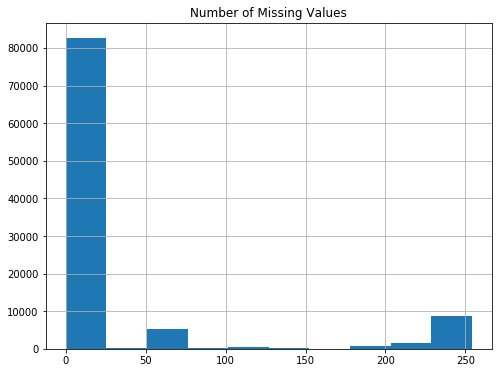

In [132]:
plot_number_missing_values_per_row(missing_values_per_row_azdias,"Number of Missing Values")


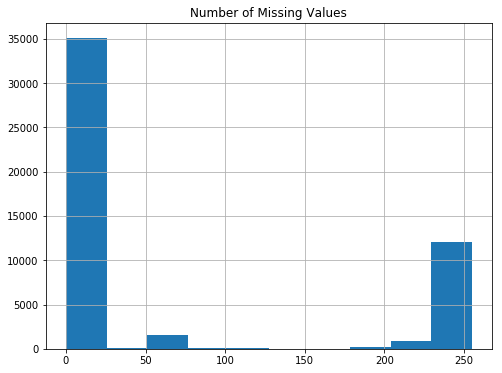

In [133]:
plot_number_missing_values_per_row(missing_values_per_row_customers,"Number of Missing Values")

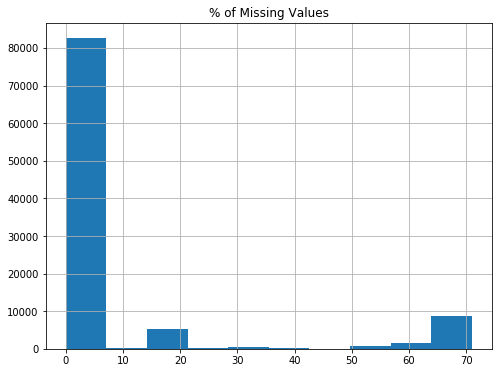

In [134]:
plot_number_missing_values_per_row(missing_values_per_row_azdias,"% of Missing Values")

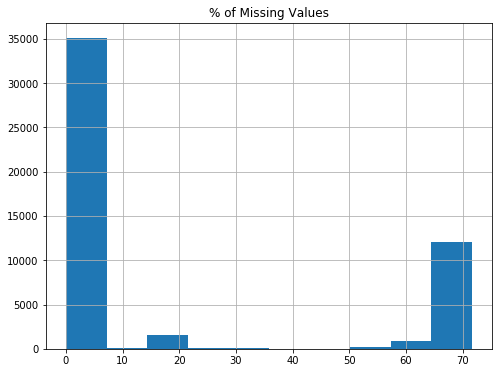

In [135]:
plot_number_missing_values_per_row(missing_values_per_row_customers,"% of Missing Values")

In [136]:
#droping this rows with too much NaN values
def drop_high_missing_rows(df,missing_values_per_row,thresold=50):
    return df[df.index.isin(list(missing_values_per_row[missing_values_per_row["% of Missing Values"]<=thresold].index))]

In [137]:
azdias_step3 = drop_high_missing_rows(azdias_step2,missing_values_per_row_azdias)
customers_step3 = drop_high_missing_rows(customers_step2,missing_values_per_row_customers)

In [138]:
print_shape_df(azdias_step3,"AZDIAS")
print_shape_df(customers_step3,"COSTUMERS")

AZDIAS
Number of rows:  88760
Number of features:  358
COSTUMERS
Number of rows:  36825
Number of features:  356


In [139]:
az_dias_description = pd.read_csv("az_dias_description.csv",sep=";")

In [140]:
#categorical features
az_dias_description[az_dias_description["Type"]=="categorical"].head(5)

,Attribute,Description,Type
0,AGER_TYP,best-ager typology,categorical
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,categorical
2,ALTER_HH,main age within the household,categorical
3,ANREDE_KZ,gender,categorical
8,BALLRAUM,distance to next urban centre,categorical


In [141]:
#plot bars of categorical features as example
def plot_bar(df,categoric_columns_examples,title):
    total = len(df)
    df_grouped = df.groupby(categoric_columns_examples)["ALTERSKATEGORIE_GROB"].count().reset_index().rename(columns={"ALTERSKATEGORIE_GROB":"Count"})
    df_grouped["%Population"] = df_grouped["Count"]/total*100
    plt.figure(figsize=(15,4))
    sns.barplot(x=categoric_columns_examples[0],y="%Population",hue=categoric_columns_examples[1],data=df_grouped).set_title(title)

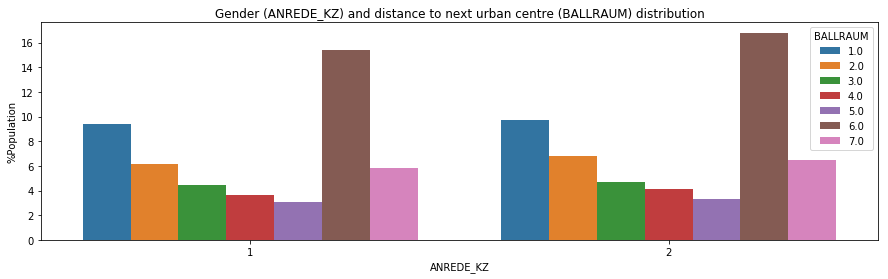

In [142]:
title = 'Gender (ANREDE_KZ) and distance to next urban centre (BALLRAUM) distribution'
categoric_columns_examples = ["ANREDE_KZ","BALLRAUM"]
plot_bar(azdias_step3,categoric_columns_examples,title)


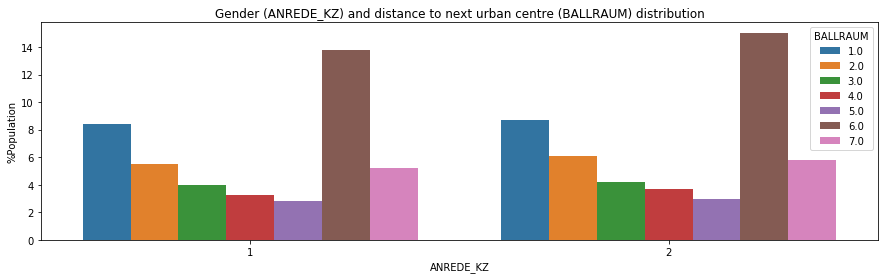

In [143]:
title = 'Gender (ANREDE_KZ) and distance to next urban centre (BALLRAUM) distribution'
categoric_columns_examples = ["ANREDE_KZ","BALLRAUM"]
plot_bar(azdias,categoric_columns_examples,title)


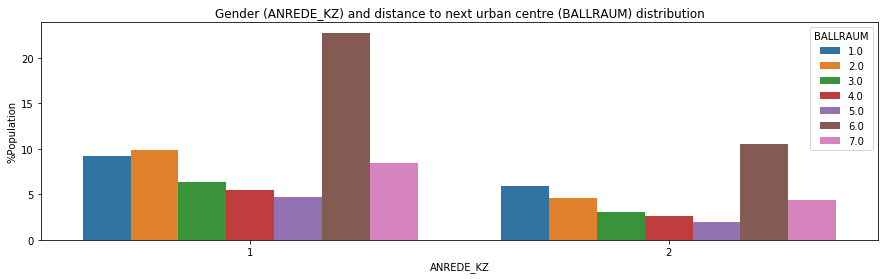

In [144]:
title = 'Gender (ANREDE_KZ) and distance to next urban centre (BALLRAUM) distribution'
categoric_columns_examples = ["ANREDE_KZ","BALLRAUM"]
plot_bar(customers_step3,categoric_columns_examples,title)


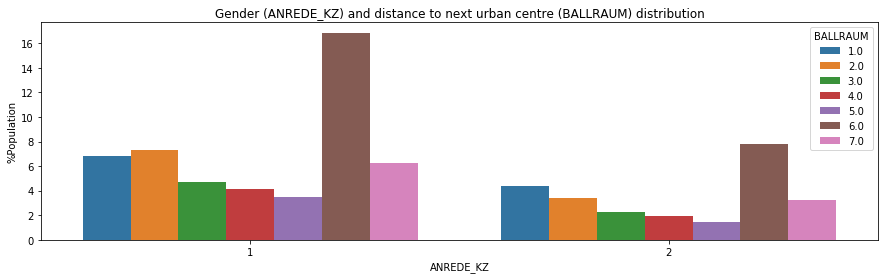

In [145]:
title = 'Gender (ANREDE_KZ) and distance to next urban centre (BALLRAUM) distribution'
categoric_columns_examples = ["ANREDE_KZ","BALLRAUM"]
plot_bar(customers,categoric_columns_examples,title)


In [146]:
#numerical features
az_dias_description_numeric = az_dias_description[az_dias_description["Type"]=="numeric"]
numeric_columns = list(az_dias_description_numeric.Attribute)
az_dias_description_numeric

,Attribute,Description,Type
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,numeric
5,ANZ_HH_TITEL,number of academic title holder in building,numeric
6,ANZ_PERSONEN,number of adult persons in the household,numeric
7,ANZ_TITEL,number of professional title holder in household,numeric
85,GEBURTSJAHR,year of birth,numeric


In [147]:
azdias_step3[numeric_columns].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR
count,88760.000000,88337.000000,88760.000000,88760.000000,88760.000000
mean,8.272014,0.039825,1.736165,0.004214,1201.770753
std,15.323960,0.301837,1.177991,0.069313,959.155699
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000,1950.000000
75%,10.000000,0.000000,2.000000,0.000000,1972.000000
max,445.000000,17.000000,38.000000,3.000000,2017.000000


In [148]:
customers_step3[numeric_columns].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR
count,36825.000000,36299.000000,36825.000000,36825.000000,36825.000000
mean,5.005648,0.070388,2.278289,0.021643,1324.268052
std,14.984378,0.577775,1.390434,0.159410,910.236646
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,0.000000,2.000000,0.000000,1939.000000
75%,4.000000,0.000000,3.000000,0.000000,1954.000000
max,395.000000,23.000000,13.000000,5.000000,2017.000000


In [149]:
#calculate features with high correlation
def get_high_correlated_features(df,sample_size,thresold):
    high_correlated_features = []
    matrix_corr = df.sample(sample_size).corr()
    processed_features = set()
    for feature_row, row in matrix_corr.iterrows():
        for feature_col in row.keys():
            if((row[feature_col]>=thresold or row[feature_col]<=-thresold) and feature_col!=feature_row and feature_col not in processed_features):
                high_correlated_features.append([feature_row,feature_col,row[feature_col]])
        processed_features.add(feature_row)
    return pd.DataFrame(high_correlated_features,columns=["feature 1", "feature 2", "correlation"])
    

In [150]:
azdias_high_correlated_features = get_high_correlated_features(azdias_step3,12000,0.8)
customers_high_correlated_features = get_high_correlated_features(customers_step3,12000,0.8)

In [151]:
azdias_high_correlated_features.sort_values("correlation").head(10)

,feature 1,feature 2,correlation
27,GREEN_AVANTGARDE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,-1.000000
26,GEMEINDETYP,ORTSGR_KLS9,-0.935285
68,WOHNLAGE_URBAN_OR_RURAL,WOHNLAGE_QUALITY,-0.893592
57,KOMBIALTER,PRAEGENDE_JUGENDJAHRE_GENERATION,-0.882761
56,KBA13_SITZE_4,KBA13_SITZE_5,-0.876017
18,D19_VERSI_ANZ_24,D19_VERSI_DATUM,-0.875202
65,SEMIO_VERT,ANREDE_KZ,-0.849022
19,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,-0.845895
17,D19_VERSI_ANZ_12,D19_VERSI_DATUM,-0.841705
70,PRAEGENDE_JUGENDJAHRE_GENERATION,LP_LEBENSPHASE_FEIN_AGE,-0.832107


In [152]:
customers_high_correlated_features.sort_values("correlation").head(10)

,feature 1,feature 2,correlation
18,GREEN_AVANTGARDE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,-1.000000
17,GEMEINDETYP,ORTSGR_KLS9,-0.931408
11,D19_VERSI_ANZ_24,D19_VERSI_DATUM,-0.887172
53,WOHNLAGE_URBAN_OR_RURAL,WOHNLAGE_QUALITY,-0.878899
14,FINANZ_SPARER,FINANZ_VORSORGER,-0.855140
10,D19_VERSI_ANZ_12,D19_VERSI_DATUM,-0.851031
43,KOMBIALTER,PRAEGENDE_JUGENDJAHRE_GENERATION,-0.847869
51,SEMIO_VERT,ANREDE_KZ,-0.840952
42,KBA13_SITZE_4,KBA13_SITZE_5,-0.820121
50,SEMIO_KULT,ANREDE_KZ,-0.810802


In [153]:
azdias_high_correlated_features.sort_values("correlation").tail(10)

,feature 1,feature 2,correlation
40,KBA13_ALTERHALTER_61,KBA13_HALTER_66,0.927515
62,LP_STATUS_FEIN,LP_STATUS_GROB,0.935411
60,LP_FAMILIE_FEIN,LP_LEBENSPHASE_GROB,0.941877
45,KBA13_BAUMAX,PLZ8_BAUMAX,0.949202
52,KBA13_KMH_211,KBA13_KMH_250,0.959386
69,CAMEO_INTL_2015_WEALTH,CAMEO_DEUG_2015_WEALTH_STATUS,0.962695
50,KBA13_HHZ,PLZ8_HHZ,0.968575
0,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE,0.978275
47,KBA13_GBZ,PLZ8_GBZ,0.980148
46,KBA13_FAB_SONSTIGE,KBA13_HERST_SONST,1.000000


In [154]:
customers_high_correlated_features.sort_values("correlation").tail(10)

,feature 1,feature 2,correlation
28,KBA13_ALTERHALTER_61,KBA13_HALTER_66,0.933323
47,LP_STATUS_FEIN,LP_STATUS_GROB,0.933851
33,KBA13_BAUMAX,PLZ8_BAUMAX,0.938069
38,KBA13_KMH_211,KBA13_KMH_250,0.960231
54,CAMEO_INTL_2015_WEALTH,CAMEO_DEUG_2015_WEALTH_STATUS,0.961431
37,KBA13_HHZ,PLZ8_HHZ,0.967643
45,LP_FAMILIE_FEIN,LP_LEBENSPHASE_GROB,0.972188
35,KBA13_GBZ,PLZ8_GBZ,0.978139
0,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE,0.990657
34,KBA13_FAB_SONSTIGE,KBA13_HERST_SONST,1.000000


In [155]:
#dropping theses features with high correlation
def drop_high_correlated_features(df,high_correlated_features,threshold=0.95):
    to_eliminate = set()
    for index,row in high_correlated_features.iterrows():
        if(row["correlation"]>=threshold or row["correlation"]<=-threshold):
            to_eliminate.add(row["feature 1"])
    print(to_eliminate)
    return df.drop(columns=to_eliminate)

In [156]:
azdias_step4 = drop_high_correlated_features(azdias_step3,azdias_high_correlated_features)
customers_step4 = drop_high_correlated_features(customers_step3,customers_high_correlated_features)

{'KBA13_HHZ', 'CAMEO_INTL_2015_WEALTH', 'KBA13_KMH_211', 'KBA13_FAB_SONSTIGE', 'ANZ_HAUSHALTE_AKTIV', 'KBA13_GBZ', 'GREEN_AVANTGARDE'}
{'KBA13_HHZ', 'LP_FAMILIE_FEIN', 'CAMEO_INTL_2015_WEALTH', 'KBA13_KMH_211', 'KBA13_FAB_SONSTIGE', 'ANZ_HAUSHALTE_AKTIV', 'KBA13_GBZ', 'GREEN_AVANTGARDE'}


In [157]:
#see features that are in azdias and not in customers
extra_columns = list(set(azdias_step4.columns)-set(customers_step4.columns))

In [158]:
extra_columns.extend(list(set(customers_step4.columns)-set(azdias_step4.columns)))

In [159]:
#droping theses features
azdias_step4.drop(columns=set(azdias_step4.columns)-set(customers_step4.columns),inplace=True)
customers_step4.drop(columns=set(customers_step4.columns)-set(azdias_step4.columns),inplace=True)
print_shape_df(customers_step4,"COSTUMERS")


COSTUMERS
Number of rows:  36825
Number of features:  348


In [160]:
print_shape_df(azdias_step4,"AZDIAS")
print_shape_df(customers_step4,"COSTUMERS")

AZDIAS
Number of rows:  88760
Number of features:  348
COSTUMERS
Number of rows:  36825
Number of features:  348


In [161]:
#ploting high correlated features
def plot_seaborn_grid_scatter_plot(df,n_cols,n_rows,correlated_features):
    import seaborn as sns; sns.set()
    f, axes = plt.subplots(n_cols, n_rows, figsize=(18, 12), sharex=False, sharey=False)
    tips = sns.load_dataset("tips")
    for n_row in range(n_rows):
        for n_col in range(n_cols):
            elements = correlated_features.pop()
            sns.scatterplot(x=elements[0], y=elements[1], data=df,ax=axes[n_col,n_row])
   

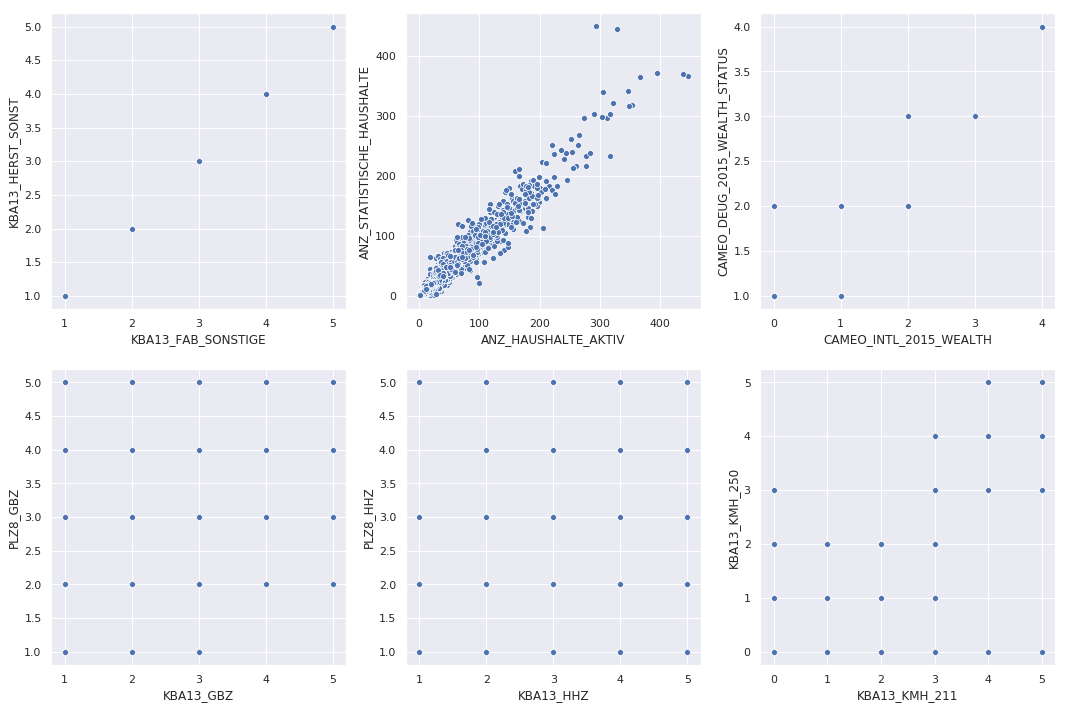

In [162]:
n_cols = 2
n_rows = 3
top_high_correlated = list(azdias_high_correlated_features.sort_values("correlation").tail(n_cols*n_rows)[["feature 1","feature 2"]].values)
plot_seaborn_grid_scatter_plot(azdias_step3,n_cols,n_rows,top_high_correlated)

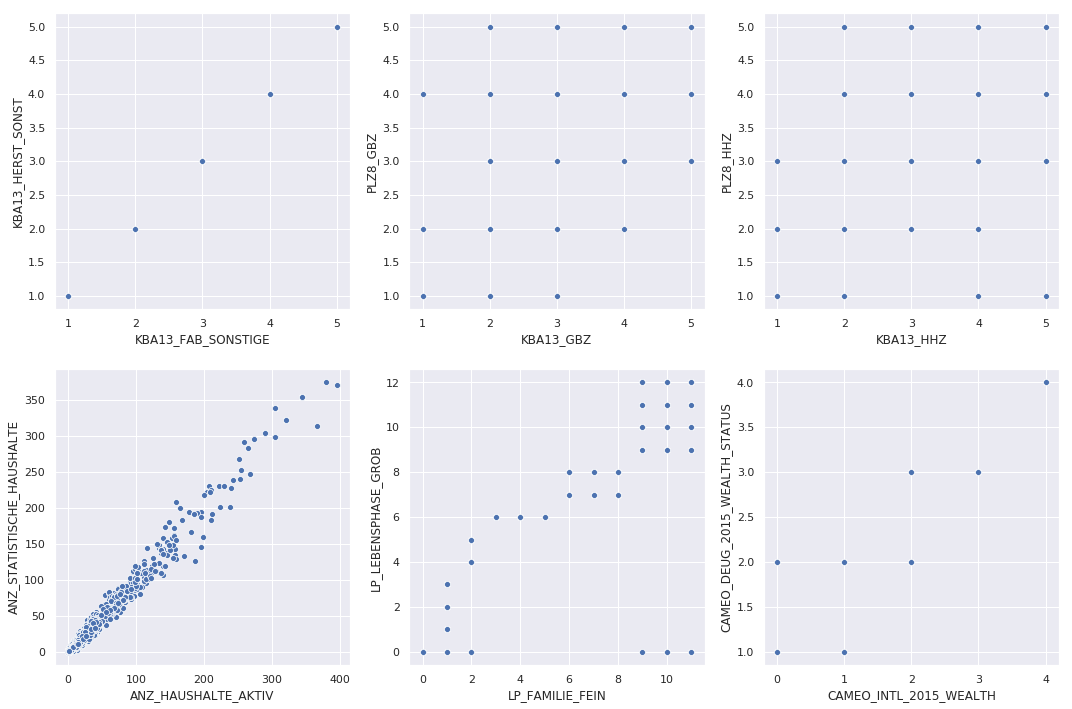

In [163]:
n_cols = 2
n_rows = 3
top_high_correlated = list(customers_high_correlated_features.sort_values("correlation").tail(n_cols*n_rows)[["feature 1","feature 2"]].values)
plot_seaborn_grid_scatter_plot(customers_step3,n_cols,n_rows,top_high_correlated)

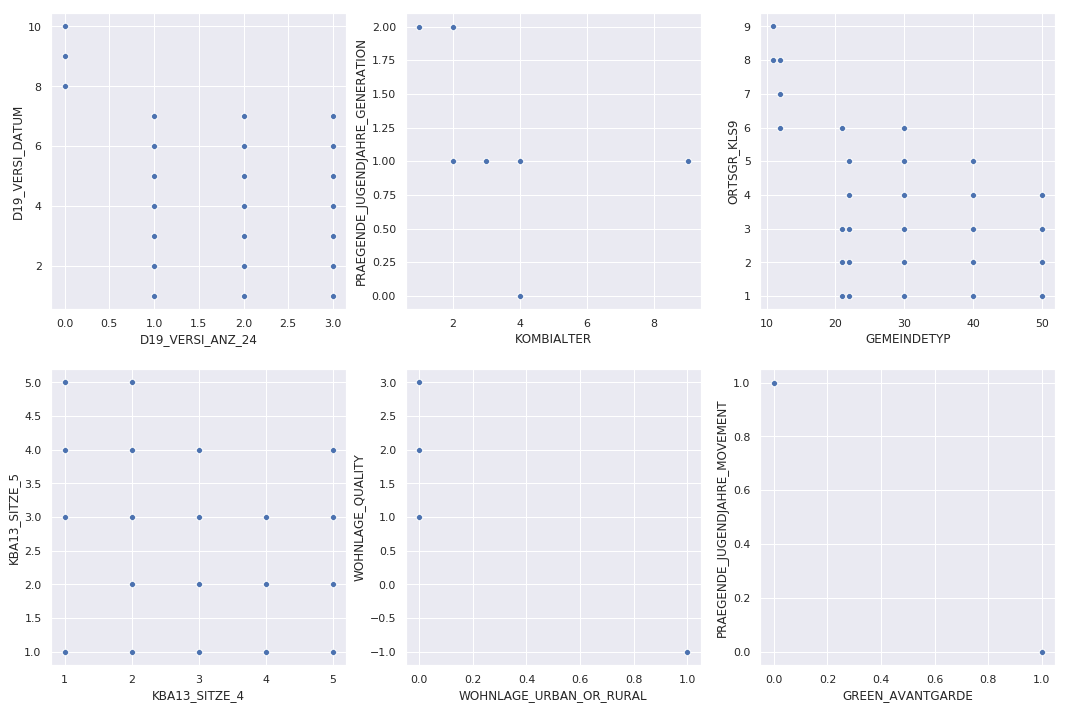

In [164]:
n_cols = 2
n_rows = 3
top_high_negative_correlated = list(azdias_high_correlated_features.sort_values("correlation").head(n_cols*n_rows)[["feature 1","feature 2"]].values)
plot_seaborn_grid_scatter_plot(azdias_step3,n_cols,n_rows,top_high_negative_correlated)

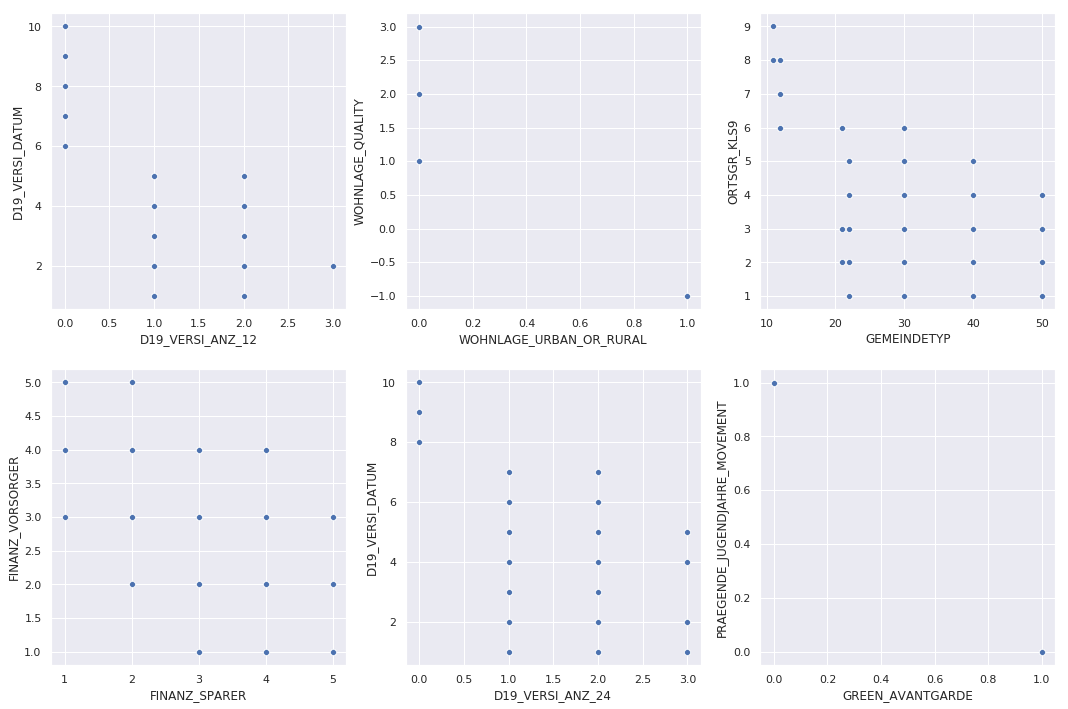

In [165]:
n_cols = 2
n_rows = 3
top_high_negative_correlated = list(customers_high_correlated_features.sort_values("correlation").head(n_cols*n_rows)[["feature 1","feature 2"]].values)
plot_seaborn_grid_scatter_plot(customers_step3,n_cols,n_rows,top_high_negative_correlated)

In [166]:
# Impute nans using most frequente values

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
azdias_step5 = imputer.fit_transform(azdias_step4)
azdias_step5 = pd.DataFrame(azdias_step5,columns=azdias_step4.columns)
azdias_step5 = azdias_step5.astype(float)

# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_step6 = scaler.fit_transform(azdias_step5)
azdias_step6 = pd.DataFrame(azdias_step6,columns=azdias_step5.columns)


In [167]:
# Impute nans using mode value
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
customers_step5= imputer.fit_transform(customers_step4)
customers_step5 = pd.DataFrame(customers_step5,columns=customers_step4.columns)
customers_step5 = customers_step5.astype(float)

# Apply feature scaling to the customers data.
scaler = StandardScaler()
customers_step6 = scaler.fit_transform(customers_step5)
customers_step6 = pd.DataFrame(customers_step6,columns=customers_step5.columns)


In [168]:
#saving intermediate results
azdias_step6.to_pickle("azdias_step6.pkl")
customers_step6.to_pickle("customers_step6.pkl")

In [169]:
azdias_step6 = pd.read_pickle("azdias_step6.pkl")
customers_step6 = pd.read_pickle("customers_step6.pkl")


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Dimensionality Reduction

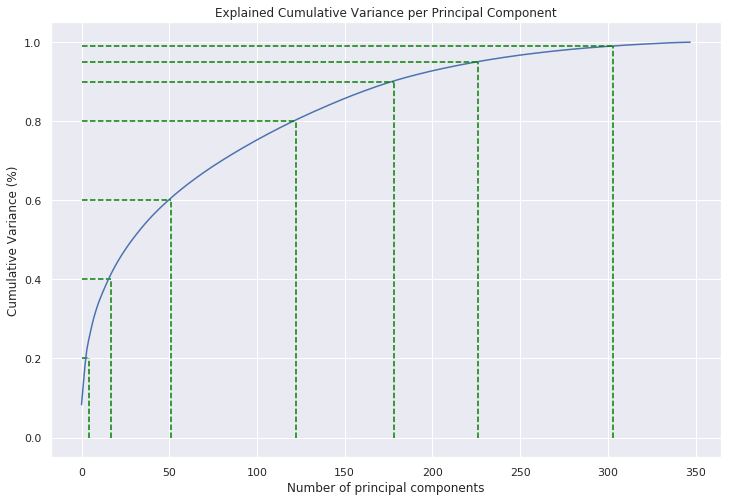

In [170]:
#ploting retained original variance
plot_curve_min_components_variance(azdias_step6,"cumulative_variance")

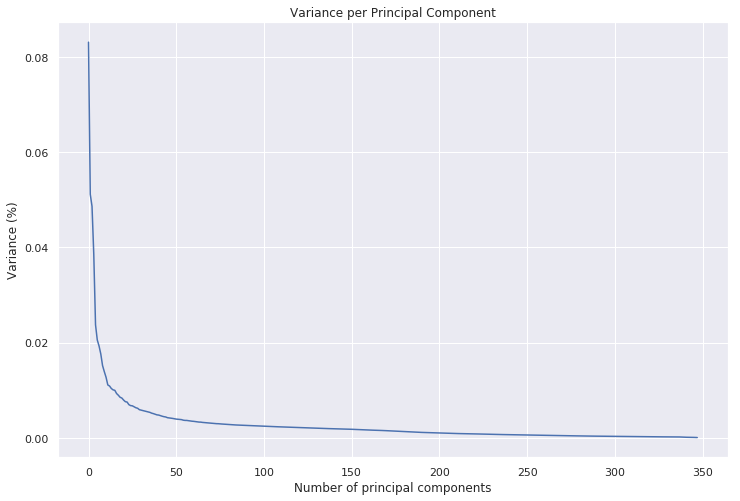

In [171]:
plot_curve_min_components_variance(azdias_step6,"explained_variance")

In [172]:
#calculating min components to retain variance
min_componentes_85 =  get_min_components_variance(azdias_step6,0.85)
min_componentes_90 =  get_min_components_variance(azdias_step6,0.90)
min_componentes_95 =  get_min_components_variance(azdias_step6,0.95)
min_componentes_99 =  get_min_components_variance(azdias_step6,0.99)
print("85% variance retained - ",min_componentes_85, " componentes")
print("90% variance retained - ",min_componentes_90, " componentes")
print("95% variance retained - ",min_componentes_95, " componentes")
print("99% variance retained - ",min_componentes_99, " componentes")

85% variance retained -  147  componentes
90% variance retained -  178  componentes
95% variance retained -  226  componentes
99% variance retained -  303  componentes


In [188]:
#getting pca for min_componentes = 95%
azdias_pca_step7 , azdias_step7 = pca_model_n_components(azdias_step6,min_componentes_95)

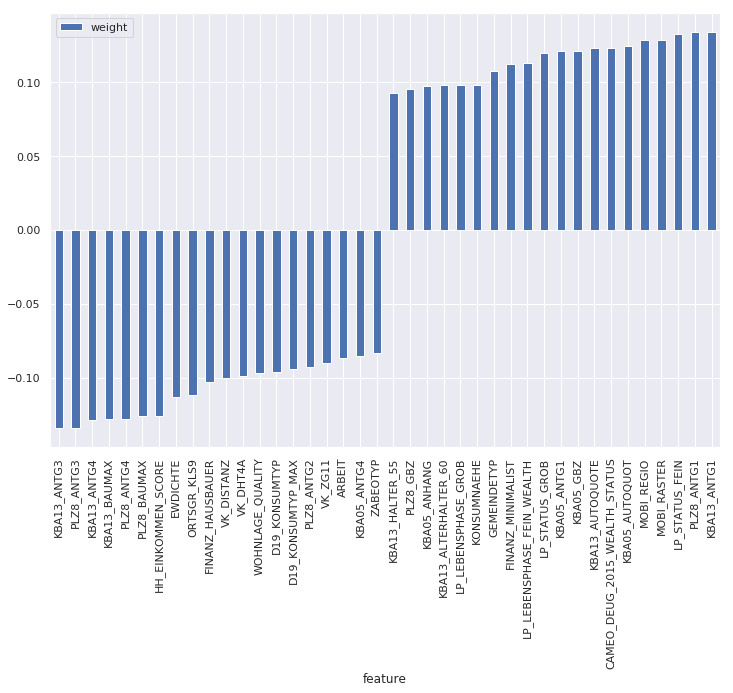

In [174]:
#Lets look to features dimension most stronger weights
#O dimension
df_weights_pca = report_features(azdias_step6.columns,azdias_pca_step7,0)
df_weights_pca_sorted_head = df_weights_pca.sort_values("weight").head(20)
df_weights_pca_sorted_tail = df_weights_pca.sort_values("weight").tail(20)
top3_negative_component0 = df_weights_pca_sorted_head.head(3).index.values
top3_positive_component0 = df_weights_pca_sorted_tail.tail(3).index.values

df_weights_pca = pd.concat([df_weights_pca_sorted_head,df_weights_pca_sorted_tail])
df_weights_pca.plot(kind="bar")


In [175]:
print(list(top3_negative_component0))
print(list(top3_positive_component0))


['KBA13_ANTG3', 'PLZ8_ANTG3', 'KBA13_ANTG4']
['LP_STATUS_FEIN', 'PLZ8_ANTG1', 'KBA13_ANTG1']


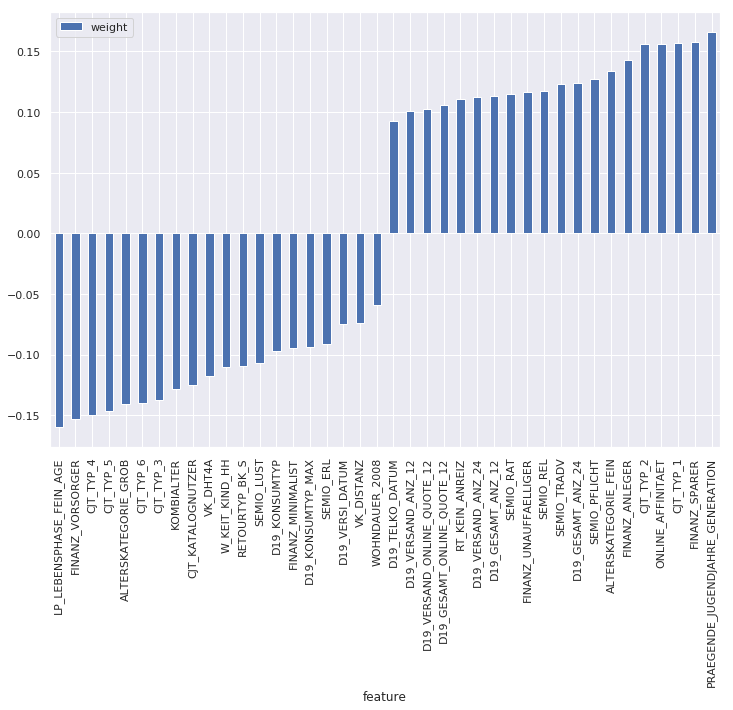

In [176]:
#Lets look to features dimension most stronger weights
#1 dimension
df_weights_pca = report_features(azdias_step6.columns,azdias_pca_step7,1)
df_weights_pca_sorted_head = df_weights_pca.sort_values("weight").head(20)
df_weights_pca_sorted_tail = df_weights_pca.sort_values("weight").tail(20)
top3_negative_component1 = df_weights_pca_sorted_head.head(3).index.values
top3_positive_component1 = df_weights_pca_sorted_tail.tail(3).index.values

df_weights_pca = pd.concat([df_weights_pca_sorted_head,df_weights_pca_sorted_tail])
df_weights_pca.plot(kind="bar")


In [177]:
print(list(top3_negative_component1))
print(list(top3_positive_component1))


['LP_LEBENSPHASE_FEIN_AGE', 'FINANZ_VORSORGER', 'CJT_TYP_4']
['CJT_TYP_1', 'FINANZ_SPARER', 'PRAEGENDE_JUGENDJAHRE_GENERATION']


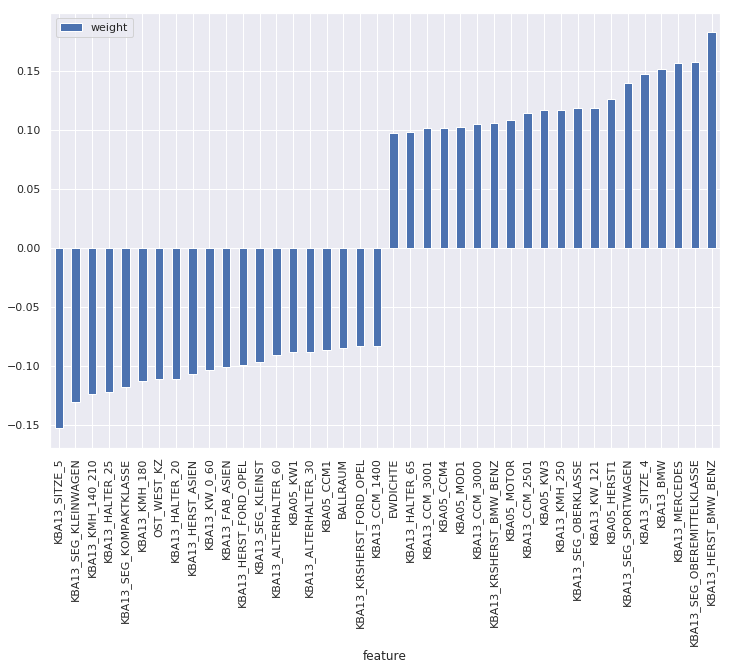

In [178]:
#Lets look to features dimension most stronger weights
#2 dimension
df_weights_pca = report_features(azdias_step6.columns,azdias_pca_step7,2)
df_weights_pca_sorted_head = df_weights_pca.sort_values("weight").head(20)
df_weights_pca_sorted_tail = df_weights_pca.sort_values("weight").tail(20)
top3_negative_component2 = df_weights_pca_sorted_head.head(3).index.values
top3_positive_component2 = df_weights_pca_sorted_tail.tail(3).index.values
df_weights_pca = pd.concat([df_weights_pca_sorted_head,df_weights_pca_sorted_tail])
df_weights_pca.plot(kind="bar")


In [179]:
print(list(top3_negative_component2))
print(list(top3_positive_component2))


['KBA13_SITZE_5', 'KBA13_SEG_KLEINWAGEN', 'KBA13_KMH_140_210']
['KBA13_MERCEDES', 'KBA13_SEG_OBEREMITTELKLASSE', 'KBA13_HERST_BMW_BENZ']


In [180]:
important_features = list()
important_features.extend(list(top3_negative_component0))
important_features.extend(list(top3_positive_component0))
important_features

['KBA13_ANTG3',
 'PLZ8_ANTG3',
 'KBA13_ANTG4',
 'LP_STATUS_FEIN',
 'PLZ8_ANTG1',
 'KBA13_ANTG1']

In [181]:
important_features = list()
important_features.extend(list(top3_negative_component0))
important_features.extend(list(top3_positive_component0))
important_features

['KBA13_ANTG3',
 'PLZ8_ANTG3',
 'KBA13_ANTG4',
 'LP_STATUS_FEIN',
 'PLZ8_ANTG1',
 'KBA13_ANTG1']

### Clustering

Analysing  2  clusters
Analysing  3  clusters
Analysing  4  clusters
Analysing  5  clusters
Analysing  6  clusters
Analysing  7  clusters
Analysing  8  clusters
Analysing  9  clusters
Analysing  10  clusters
Analysing  11  clusters
Analysing  12  clusters
Analysing  13  clusters
Analysing  14  clusters
Analysing  15  clusters
Analysing  16  clusters
Analysing  17  clusters
Analysing  18  clusters
Analysing  19  clusters


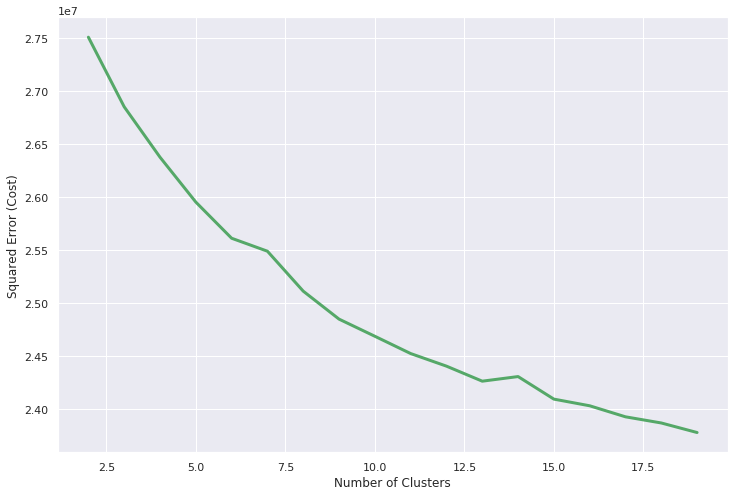

In [182]:
#plot clustering
plot_clustering(azdias_step7)

In [183]:
#using 10 clusters
fitted_model_k_means = do_clustering(azdias_step7,10)

In [187]:
azdias_step7.shape

(88760, 226)

In [186]:
set(azdias_step6.columns)-set(customers_step6.columns)

set()

In [189]:
customers_step7 = azdias_pca_step7.transform(customers_step6)
customers_step6["cluster_number"] = fitted_model_k_means.predict(customers_step7)

In [194]:
azdias_step6["cluster_number"] = fitted_model_k_means.predict(azdias_step7)

In [195]:
clusters_customers_percent = customers_step6.groupby(["cluster_number"])["AKT_DAT_KL"].count().reset_index().rename(columns = {"AKT_DAT_KL":"%"})
clusters_customers_percent["%"] = clusters_customers_percent["%"]/len(customers_step6)*100

In [196]:
clusters_customers_percent

,cluster_number,%
0,0,11.065852
1,1,16.825526
2,2,12.448065
3,3,15.522064
4,4,8.513238
5,5,3.459606
6,6,4.825526
7,7,7.247794
8,8,7.446029
9,9,12.646300


In [197]:
clusters_azdias_percent = azdias_step6.groupby(["cluster_number"])["AKT_DAT_KL"].count().reset_index().rename(columns = {"AKT_DAT_KL":"%"})
clusters_azdias_percent["%"] = clusters_azdias_percent["%"]/len(azdias_step6)*100

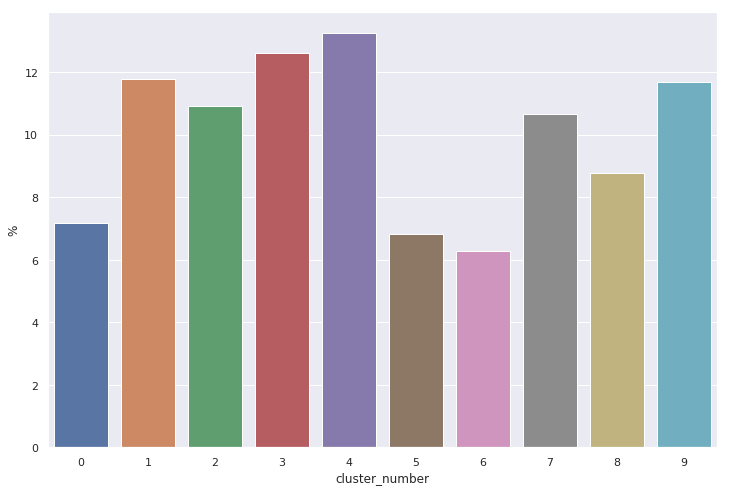

In [198]:
#Clusters percentages in Azdias

ax = sns.barplot(x="cluster_number",y = "%", data=clusters_azdias_percent)

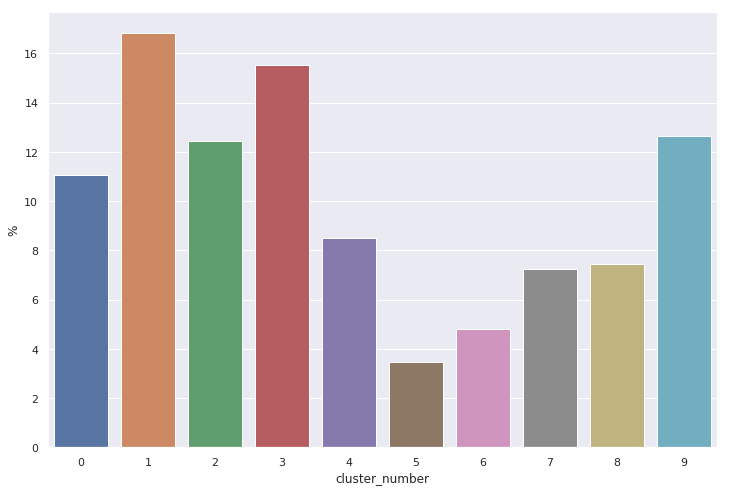

In [199]:
#Clusters percentages in customers

ax = sns.barplot(x="cluster_number",y = "%", data=clusters_customers_percent)

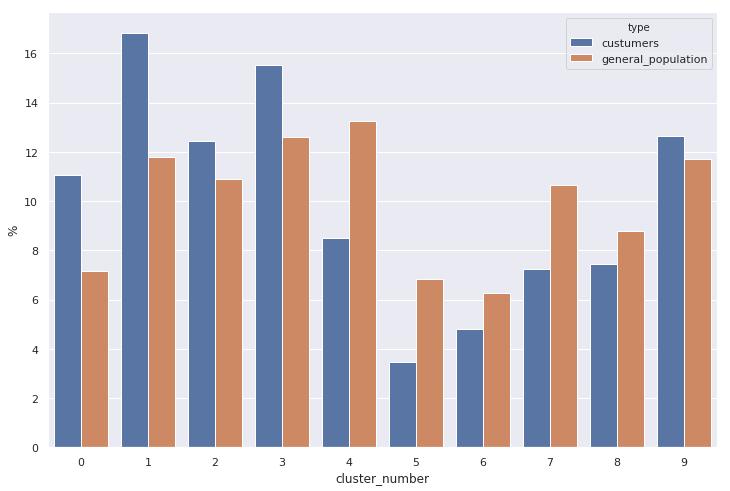

In [200]:
clusters_customers_percent["type"]="custumers"
clusters_azdias_percent["type"]="general_population"
clusters = pd.concat([clusters_customers_percent,clusters_azdias_percent])

ax = sns.barplot(x="cluster_number",y = "%", hue="type", data=clusters)


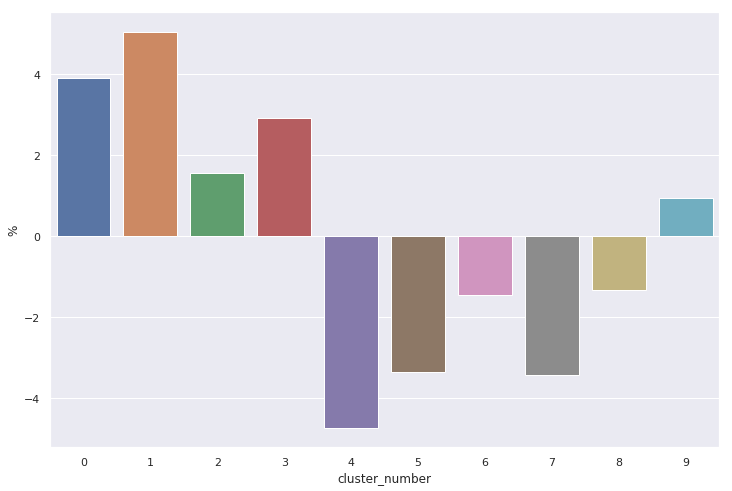

In [201]:
#Diferrence betweeen clusters percentages


ax = sns.barplot(y = clusters_customers_percent.sort_values("cluster_number")["%"]-clusters_azdias_percent.sort_values("cluster_number")["%"],x = clusters_customers_percent.sort_values("cluster_number")["cluster_number"], data=clusters_customers_percent)


In [202]:
most_diference_clusters = [2,0,6,7]
most_equal_clusters = [3,5,8]

In [203]:
import squarify


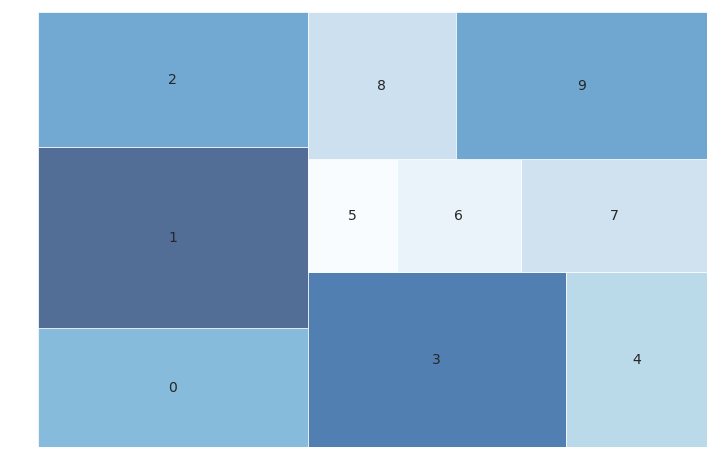

In [204]:
import matplotlib

volume = clusters_customers_percent.sort_values(["cluster_number"])["%"].values
labels = clusters_customers_percent.sort_values(["cluster_number"])["cluster_number"].values

norm = matplotlib.colors.Normalize(vmin=min(volume), vmax=max(volume))

color_list = [matplotlib.cm.Blues(norm(value)) for value in volume]

plt.rc('font', size=14)
squarify.plot(sizes=volume, label=labels,
              color=color_list, alpha=0.7)
plt.axis('off')

plt.show()

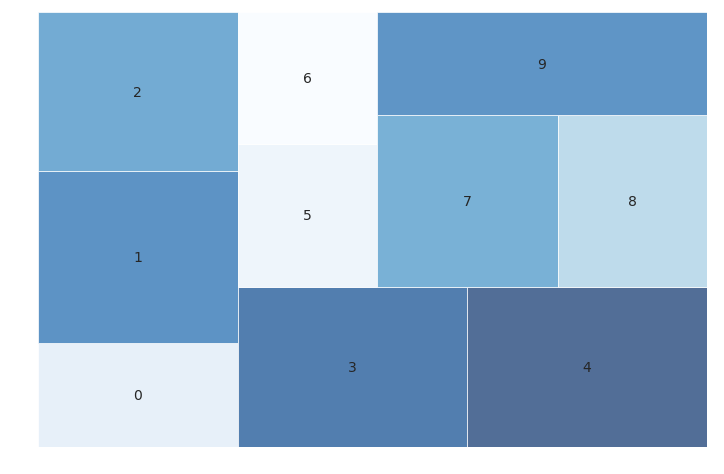

In [205]:
import matplotlib

volume = clusters_azdias_percent.sort_values(["cluster_number"])["%"].values
labels = clusters_azdias_percent.sort_values(["cluster_number"])["cluster_number"].values

norm = matplotlib.colors.Normalize(vmin=min(volume), vmax=max(volume))

color_list = [matplotlib.cm.Blues(norm(value)) for value in volume]

plt.rc('font', size=14)
squarify.plot(sizes=volume, label=labels,
              color=color_list, alpha=0.7)
plt.axis('off')

plt.show()

In [206]:
clusters_customers_percent = customers_step6.groupby(["cluster_number"])["AKT_DAT_KL"].count().reset_index().rename(columns = {"AKT_DAT_KL":"%"})
clusters_customers_percent["%"] = clusters_customers_percent["%"]/len(customers_step6)*100


In [207]:
azdias_important_clusters = azdias_step6.groupby("cluster_number")[important_features].mean().reset_index()
custumers_important_clusters = customers_step6.groupby("cluster_number")[important_features].mean().reset_index()
azdias_important_clusters["type"]="general_population"
custumers_important_clusters["type"]="custumers"

important_clusters = pd.concat([azdias_important_clusters,custumers_important_clusters])

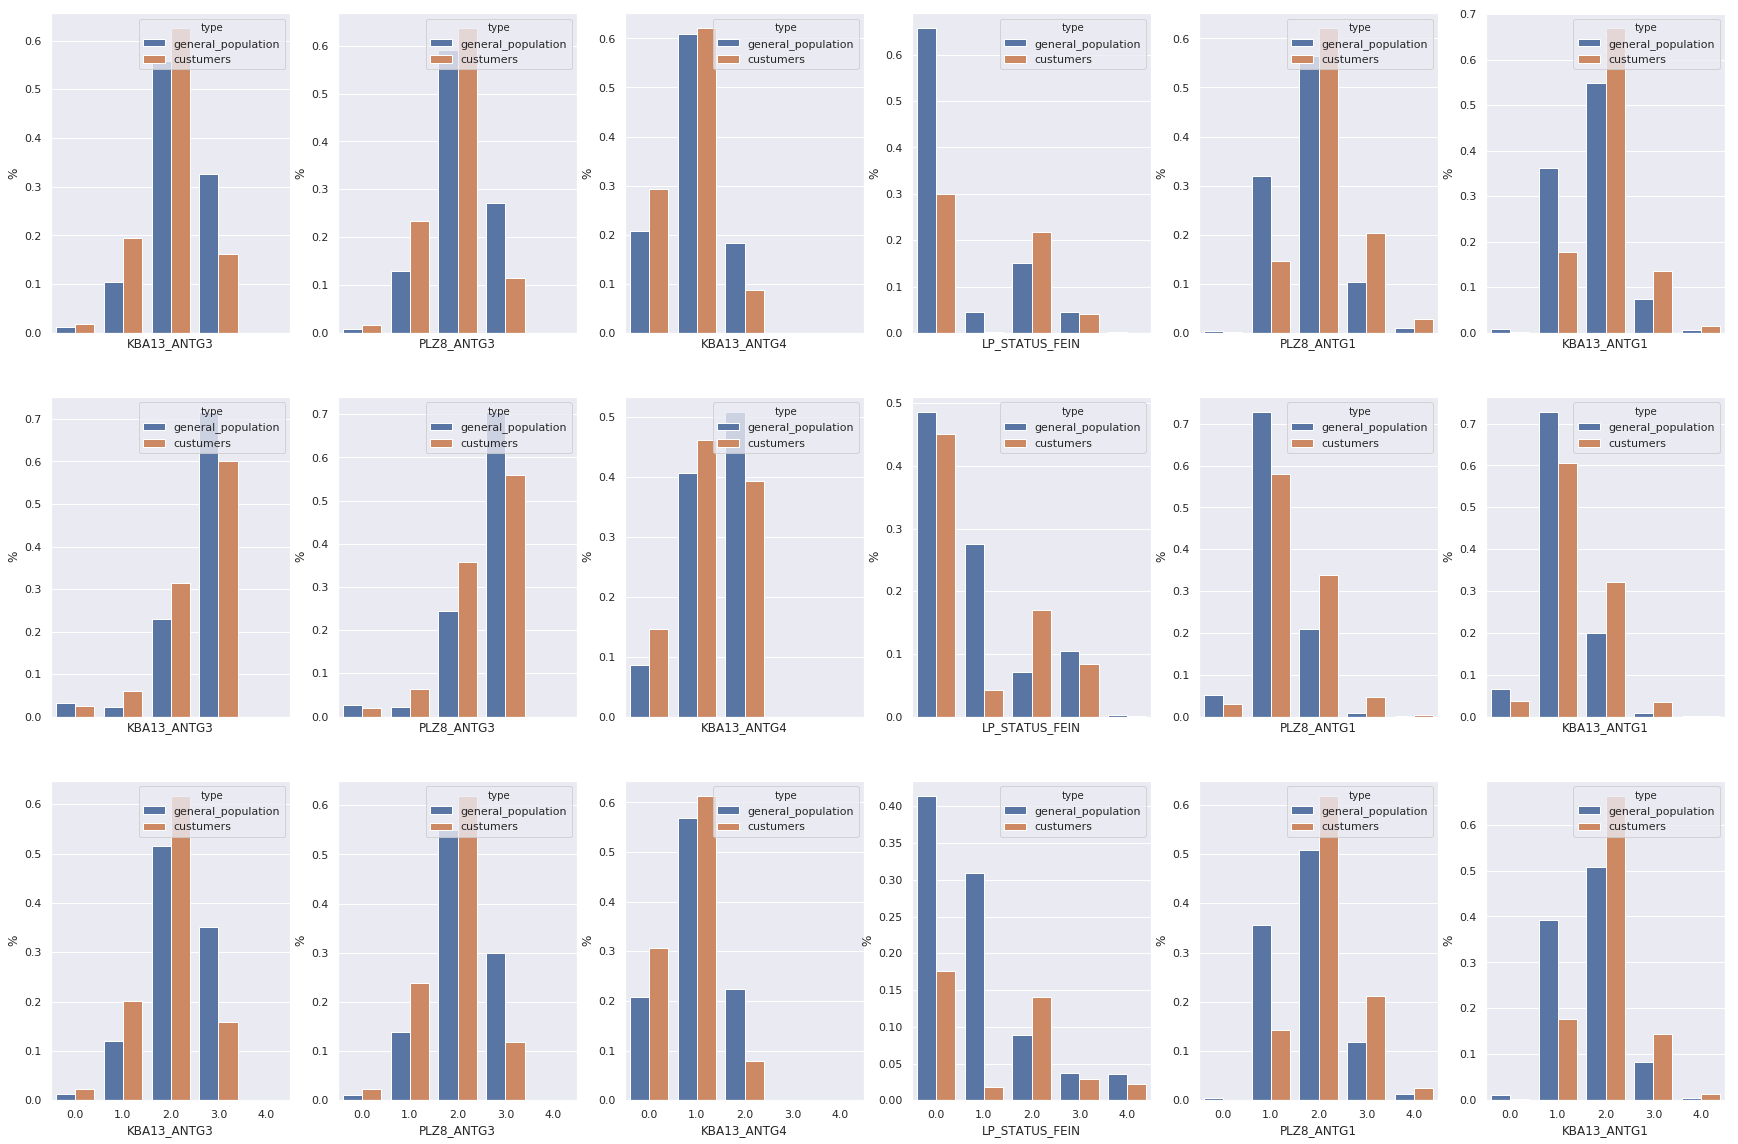

In [208]:
azdias_step5["cluster_number"] = azdias_step6["cluster_number"]
customers_step5["cluster_number"] = customers_step6["cluster_number"]

f, axes = plt.subplots(len(most_equal_clusters), len(important_features), figsize=(30, 20), sharex=True)


for i,feature in enumerate(important_features):
    for j,cluster in enumerate(most_equal_clusters):
        azdias_cluster = azdias_step5[azdias_step5["cluster_number"]==cluster]
        custumer_cluster = customers_step5[customers_step5["cluster_number"]==cluster]
        azdias_important_clusters = azdias_cluster.groupby([feature])["AKT_DAT_KL"].count().reset_index().rename(columns={"AKT_DAT_KL":"%"})
        azdias_important_clusters["%"] = azdias_important_clusters["%"]/len(azdias_cluster)
        custumer_important_clusters = custumer_cluster.groupby([feature])["AKT_DAT_KL"].count().reset_index().rename(columns={"AKT_DAT_KL":"%"})
        custumer_important_clusters["%"] = custumer_important_clusters["%"]/len(custumer_cluster)
        azdias_important_clusters["type"]="general_population"
        custumer_important_clusters["type"]="custumers"
        important_clusters = pd.concat([azdias_important_clusters,custumer_important_clusters])
        sns.barplot(x=feature,y="%",hue="type",data=important_clusters, ax=axes[j, i])

f.savefig("most-equal-features.png")





## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [211]:
mailout_train = pd.read_csv('train.csv', sep=';')

/home/lexlabs/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [212]:
mailout_test = pd.read_csv('test.csv', sep=';')

/home/lexlabs/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [215]:
#Resampling: downsample majority class

df_majority = mailout_train[mailout_train["RESPONSE"]==0].reset_index()
df_minority = mailout_train[mailout_train["RESPONSE"]==1].reset_index()

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=int(len(mailout_train)*0.8),     # to match minority class
                                 random_state=123) # reproducible results
mailout_train_downsample = pd.concat([df_majority_downsampled,df_minority]).reset_index().sample(frac=1)

In [216]:
#Response training data
response = mailout_train["RESPONSE"]
del  mailout_train["RESPONSE"]
#Response downsample training data
response_downsample = mailout_train_downsample["RESPONSE"]
del  mailout_train_downsample["RESPONSE"]


In [39]:
#mail_train_eng = pd.read_pickle("mail_train_eng.pkl")
#mail_test_eng = pd.read_pickle("mail_test_eng.pkl")



### Train and Test Processing

In [217]:
#processing training and test data and downsample

mailout_train_processed = pre_processing(mailout_train)
mailout_test_processed = pre_processing(mailout_test)
mailout_train_downsample_processed = pre_processing(mailout_train_downsample)

mailout_train_mapped  = map_to_unkown(mailout_train_processed)
mailout_test_mapped  = map_to_unkown(mailout_test_processed)
mailout_train_downsample_mapped = map_to_unkown(mailout_train_downsample_processed)



mail_train_eng = feature_eng(mailout_train_mapped)
mail_test_eng = feature_eng(mailout_test_mapped)
mailout_train_downsample_eng = feature_eng(mailout_train_downsample_mapped)


columns_to_drop  =  set(mail_train_eng.columns)-set(azdias_step6.columns)


for column in columns_to_drop:
    if column in mail_train_eng.columns:
        mail_train_eng.drop(columns=column,inplace=True)
        
        
for column in columns_to_drop:
    if column in mail_test_eng.columns:
        mail_test_eng.drop(columns=column,inplace=True)
        
for column in columns_to_drop:
    if column in mailout_train_downsample_eng.columns:
        mailout_train_downsample_eng.drop(columns=column,inplace=True)        
        
mail_train_eng = mail_train_eng.astype(float)
mail_test_eng = mail_test_eng.astype(float)
mailout_train_downsample_eng = mailout_train_downsample_eng.astype(float)



x_train = transform_and_scale(mail_train_eng,imputer_strategy="most_frequent")
x_train_downsample = transform_and_scale(mailout_train_downsample_eng,imputer_strategy="most_frequent")

y_train = response
y_train_downsample = response_downsample

x_test = transform_and_scale(mail_test_eng,imputer_strategy="most_frequent")

0  rows processed
1000  rows processed
2000  rows processed
3000  rows processed
4000  rows processed
5000  rows processed
6000  rows processed
7000  rows processed
8000  rows processed
9000  rows processed
10000  rows processed
11000  rows processed
12000  rows processed
13000  rows processed
14000  rows processed
15000  rows processed
16000  rows processed
17000  rows processed
18000  rows processed
19000  rows processed
20000  rows processed
21000  rows processed
22000  rows processed
23000  rows processed
24000  rows processed
25000  rows processed
26000  rows processed
27000  rows processed
28000  rows processed
29000  rows processed
30000  rows processed
31000  rows processed
32000  rows processed
33000  rows processed
34000  rows processed
35000  rows processed
36000  rows processed
37000  rows processed
38000  rows processed
39000  rows processed
40000  rows processed
41000  rows processed
42000  rows processed
0  rows processed
1000  rows processed
2000  rows processed
3000  r

In [42]:
#adding cluster features

#training
df_x_train = pd.DataFrame(x_train)
mail_train_eng_transformed = azdias_pca_step7.transform(x_train)
df_x_train["cluster_number"] = fitted_model_k_means.predict(mail_train_eng_transformed)/9
x_train = df_x_train.values

#test
df_x_test = pd.DataFrame(x_test)
mail_test_eng_transformed = azdias_pca_step7.transform(x_test)
df_x_test["cluster_number"] = fitted_model_k_means.predict(mail_test_eng_transformed)/9
x_test = df_x_test.values


#downsample
df_x_train_downsample = pd.DataFrame(x_train_downsample)
mail_train_eng_downsample_transformed = azdias_pca_step7.transform(df_x_train_downsample)
df_x_train_downsample["cluster_number"] = fitted_model_k_means.predict(mail_train_eng_downsample_transformed)/9
x_train_downsample = df_x_train_downsample.values

### Clustering on Training Data

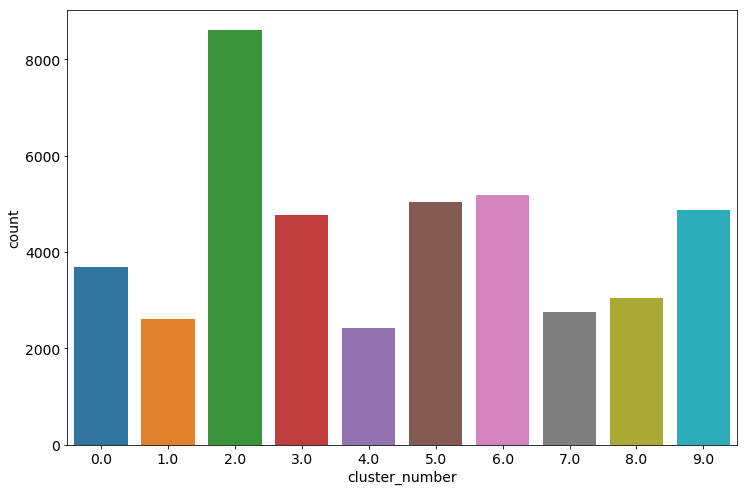

In [43]:
#ploting cluster feature

df_x_train["cluster_number"] = df_x_train["cluster_number"]*9
df_x_train["response"] = y_train
df_mailout = df_x_train.groupby(["cluster_number","response"]).count()[0].reset_index().rename(columns={0:"count"})
rcParams['figure.figsize'] = 12, 8
sns.countplot(x="cluster_number",data=df_x_train)

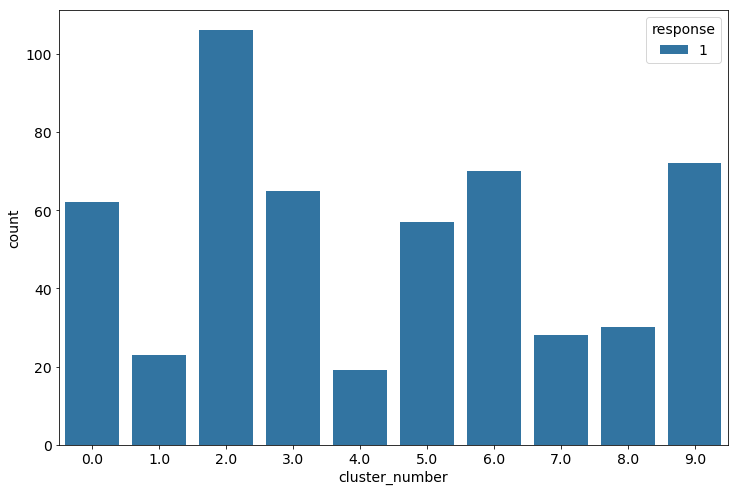

In [44]:
#plotting cluster number for response 1

rcParams['figure.figsize'] = 12, 8

sns.barplot(x="cluster_number",y="count",hue="response",data=df_mailout[df_mailout["response"]==1])

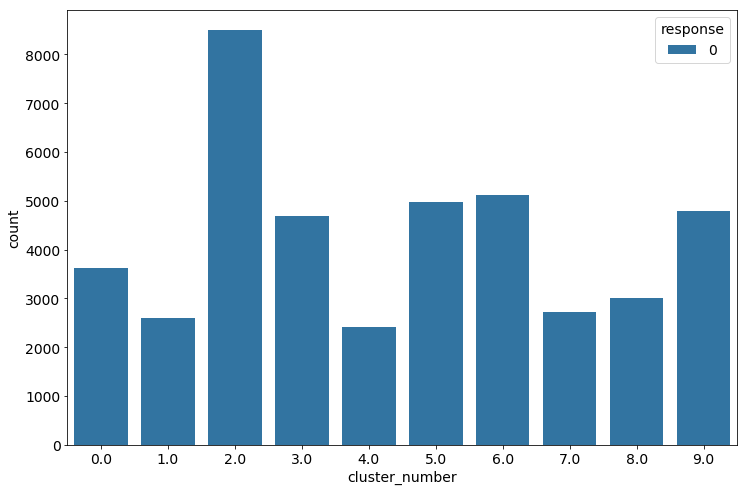

In [45]:
#plotting cluster number for response 0


rcParams['figure.figsize'] = 12, 8

sns.barplot(x="cluster_number",y="count",hue="response",data=df_mailout[df_mailout["response"]==0])

In [46]:
#model selecition

cv = model_selection.StratifiedKFold(n_splits=3)


In [47]:
#learning curve

def plot_learning_curve(estimator, 
                        title, 
                        X, 
                        y, 
                        ylim=None, 
                        cv=None,
                        n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(16,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = model_selection.learning_curve(estimator, 
                                                            X, y, cv=cv, 
                                                            n_jobs=n_jobs, 
                                                            train_sizes=train_sizes,
                                                            scoring="roc_auc")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")


    plt.legend(loc="best")
    return plt

In [53]:
#xgboost params
params_xgboost = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.01, 0.1, 1.0],
        'max_depth': [3, 10, 30],
        'n_estimators': [200,500,800],
        'max_delta_step':[0,5,10,15,20],
        'scale_pos_weight': [1,40,80]
        }

clf_xgb = xgb.XGBClassifier(
        objective = 'binary:logistic',
        eval_metric = 'auc',
    )


In [54]:
#random forest params

params_rf = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 2000],
 'class_weight' :['balanced','balanced_subsample',None]}


clf_rf = RandomForestClassifier()

In [55]:
#logistic regression params

params_lr = {
    'penalty':['l1', 'l2', 'elasticnet'],        # l1 is Lasso, l2 is Ridge
    'solver':['liblinear'],
    'C': np.linspace(0.00002,1,100),
    'class_weight':["balanced",None]
}


clf_lr = LogisticRegression()

In [56]:
#print execution time
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))





In [218]:
#do grid search
def do_grid_search(model,params,cv, x_train, y_train):
   grid = RandomizedSearchCV(model,params, scoring = 'roc_auc', cv=cv,n_jobs=-1,verbose=10,n_iter=300).fit(x_train,y_train)
   return grid

### Baseline Models

In [221]:
#Base Models
SEED = 42
base_models = []
base_models.append(('LR', LogisticRegression(solver='liblinear', random_state=SEED)))
base_models.append(('RF', RandomForestClassifier(random_state=SEED)))
base_models.append(('XGB', xgb.XGBClassifier(random_state=SEED)))

for name,base_model in base_models:
    base_model.fit(x_train,y_train)

### Logistic Regression, Random Forest and XgBoost Model

In [ ]:
start_time = timer(None) # timing starts from this point for "start_time" variable
xgboost_grid = do_grid_search(clf_xgb,params_xgboost,cv, x_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

In [37]:
start_time = timer(None) # timing starts from this point for "start_time" variable
lr_grid = do_grid_search(clf_lr,params_lr,cv, x_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9


 Time taken: 0 hours 49 minutes and 37.2 seconds.


In [21]:
start_time = timer(None) # timing starts from this point for "start_time" variable
rf_grid = do_grid_search(clf_rf,params_rf,cv, x_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 38.9min
/home/lexlabs/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_job


 Time taken: 7 hours 3 minutes and 22.07 seconds.


### DownSample Approach

In [ ]:
#Random Forest Downsample

start_time = timer(None) # timing starts from this point for "start_time" variable
rf_grid_downsample = do_grid_search(clf_rf,params_rf,cv, x_train_downsample, y_train_downsample)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
#Logistic Regression Downsample

start_time = timer(None) # timing starts from this point for "start_time" variable
lr_grid_downsample = do_grid_search(clf_lr,params_lr,cv, x_train_downsample, y_train_downsample)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
#XgBoost Downsample

start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_grid_downsample = do_grid_search(clf_xgb,params_xgboost,cv, x_train_downsample, y_train_downsample)
timer(start_time) # timing ends here for "start_time" variable

In [172]:
#pickle.dump(rf_grid, open("rf_grid_1.pkl","wb"))
rf_grid = pickle.load(open("rf_grid_1.pkl","rb"))

In [173]:
#pickle.dump(lr_grid, open("lr_grid_1.pkl","wb"))
lr_grid = pickle.load(open("lr_grid_1.pkl","rb"))

In [174]:
#pickle.dump(xgboost_grid, open("xgboost_grid_1.pkl","wb"))
xgboost_grid = pickle.load(open("xgboost_grid_1.pkl","rb"))

In [ ]:
#logistic regression downsample
lr_downsample = pickle.load(open("lr_grid_1_downsample.pkl","rb"))


In [ ]:
#random forest downsample
rf_downsample = pickle.load(open("rf_grid_1_downsample.pkl","rb"))


In [ ]:
#xgboost downsample
xgboost_grid_downsample = pickle.load(open("xgboost_grid_downsample.pkl","rb"))

### Roc-AUC score -  training data

In [175]:
hsh = {}
hsh["Logistic Regression DownSample"] = roc_auc_score(y_train,lr_downsample.predict_proba(x_train)[:,1])
hsh["Random Forest DownSample"] = roc_auc_score(y_train,rf_downsample.predict_proba(x_train)[:,1])
hsh["XgBoost DownSample"] = roc_auc_score(y_train,xgboost_grid_downsample.predict_proba(x_train)[:,1])
hsh["XgBoost Baseline"] = roc_auc_score(y_train,base_models[2][1].predict_proba(x_train)[:,1])
hsh["Random Forest Baseline"] = roc_auc_score(y_train,base_models[1][1].predict_proba(x_train)[:,1])
hsh["Logistic Regression Baseline"] = roc_auc_score(y_train,base_models[0][1].predict_proba(x_train)[:,1])
hsh["Logistic Regression"] = roc_auc_score(y_train,lr_grid.best_estimator_.predict_proba(x_train)[:,1])
hsh["Random Forest"] = roc_auc_score(y_train,xgboost_grid.best_estimator_.predict_proba(x_train)[:,1])
hsh["XgBoost"] = roc_auc_score(y_train,rf_grid.best_estimator_.predict_proba(x_train)[:,1])






In [205]:
rows = []
for key in hsh.keys():
    value = hsh[key]
    rows.append([key,value])
clf_scores = pd.DataFrame(rows,columns=["Classifier","ROC-AUC Score"]).set_index("Classifier")

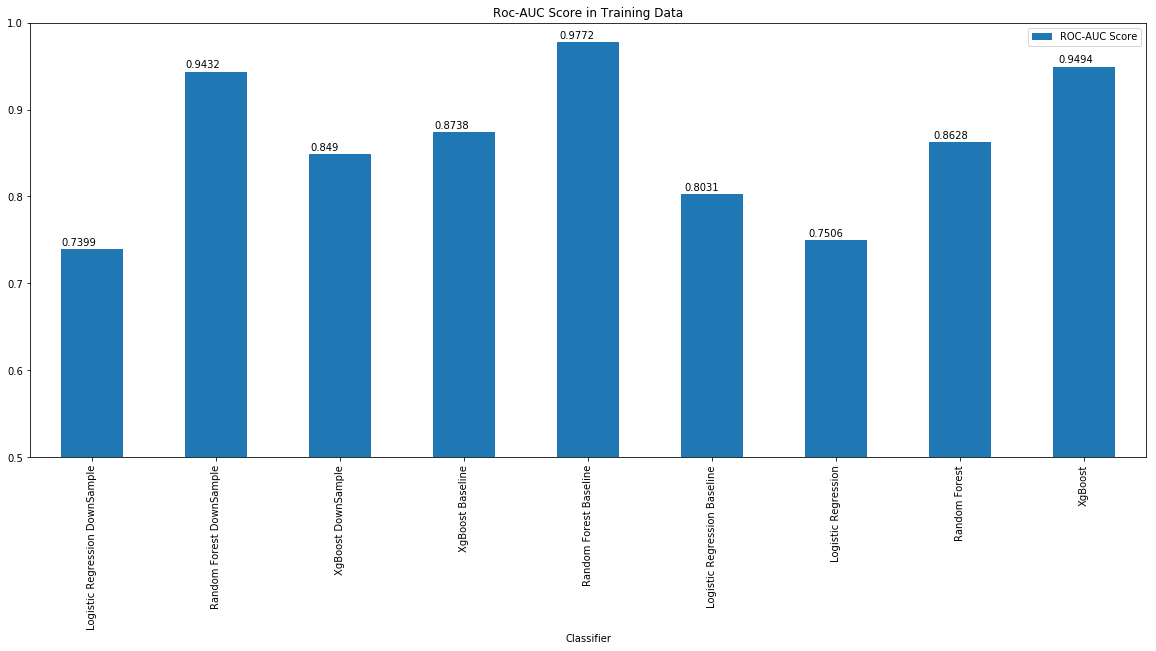

In [209]:
#plotting roc-auc score in training data

rcParams['figure.figsize'] = 20, 8

ax = clf_scores.plot(kind="bar",title="Roc-AUC Score in Training Data",ylim=[0.5,1.0])

for p in ax.patches:
    ax.annotate(str(p.get_height().round(4)), (p.get_x() * 1.005, (p.get_height() * 1.005)))

### Plotting Learning Curve

<module 'matplotlib.pyplot' from '/home/lexlabs/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

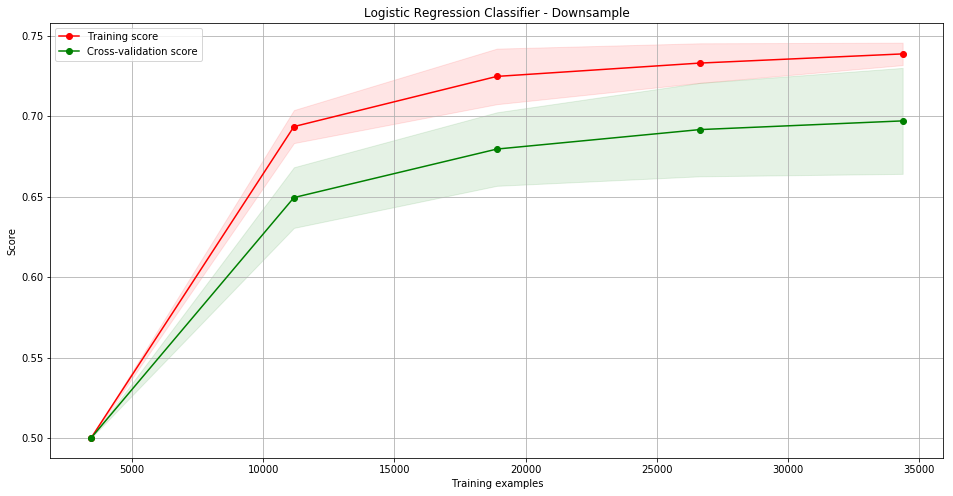

In [19]:
plot_learning_curve(lr_downsample.best_estimator_, 
                        "Logistic Regression Classifier - Downsample", 
                        x_train, 
                        y_train)

<module 'matplotlib.pyplot' from '/home/lexlabs/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

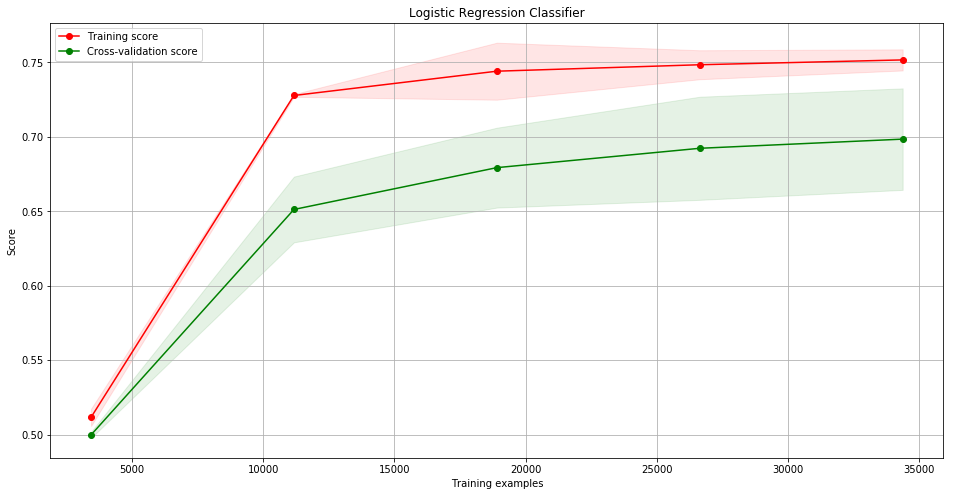

In [22]:
plot_learning_curve(lr_grid.best_estimator_, 
                        "Logistic Regression Classifier", 
                        x_train, 
                        y_train)

/home/lexlabs/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


<module 'matplotlib.pyplot' from '/home/lexlabs/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

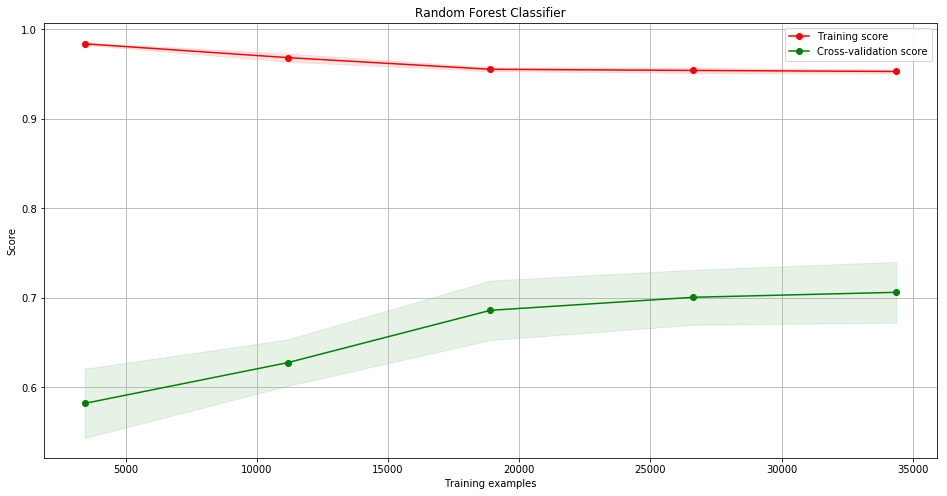

In [23]:
plot_learning_curve(rf_grid.best_estimator_, 
                        "Random Forest Classifier", 
                        x_train, 
                        y_train)

<module 'matplotlib.pyplot' from '/home/lexlabs/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

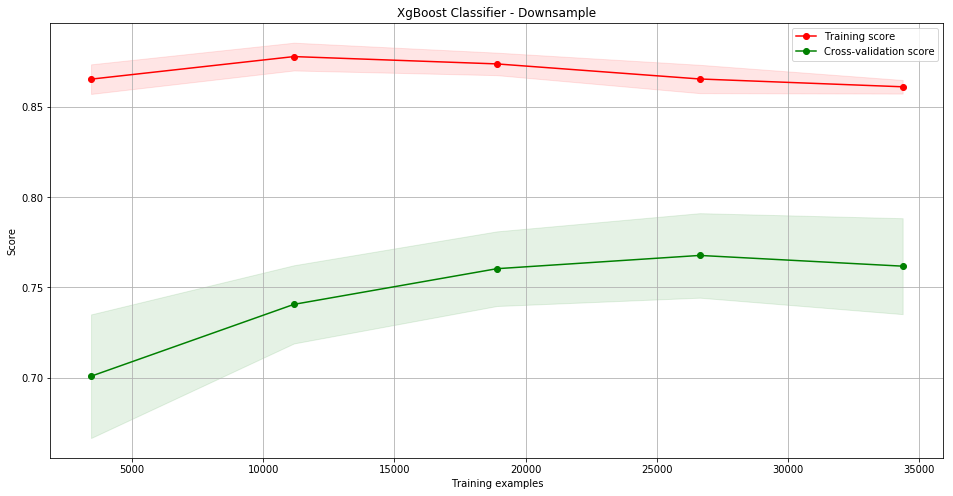

In [22]:
plot_learning_curve(xgboost_grid_downsample.best_estimator_, 
                        "XgBoost Classifier - Downsample", 
                        x_train, 
                        y_train)

<module 'matplotlib.pyplot' from '/home/lexlabs/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

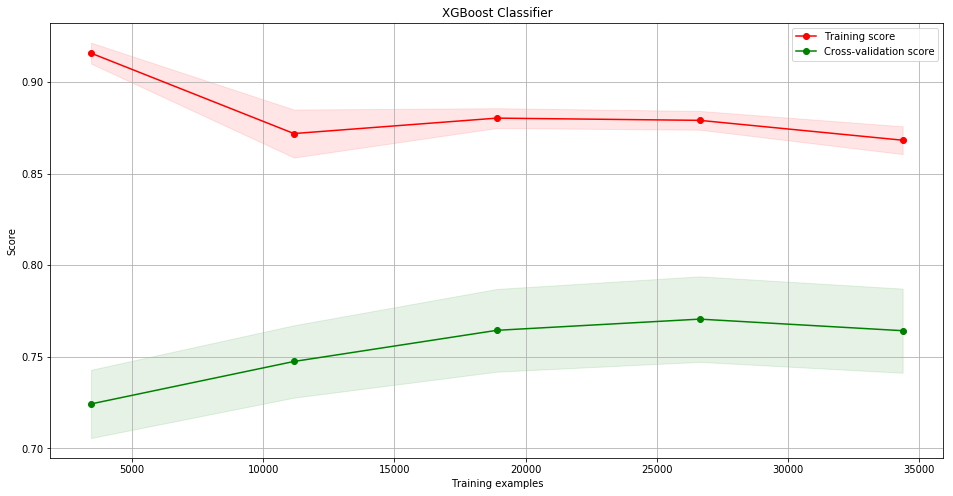

In [23]:
plot_learning_curve(xgboost_grid.best_estimator_, 
                        "XGBoost Classifier", 
                        x_train, 
                        y_train)

<module 'matplotlib.pyplot' from '/home/lexlabs/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

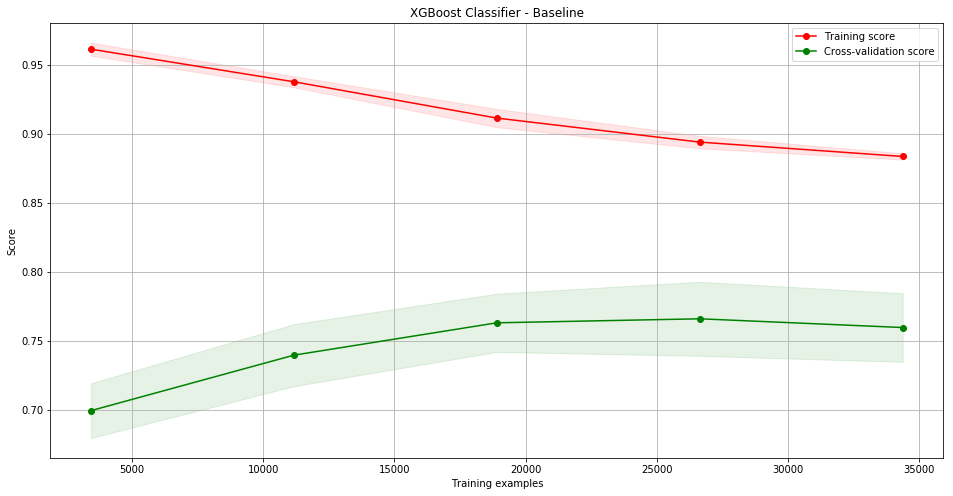

In [62]:
xgboost_baseline = base_models[2][1]
plot_learning_curve(xgboost_baseline, 
                        "XGBoost Classifier - Baseline", 
                        x_train, 
                        y_train)

<module 'matplotlib.pyplot' from '/home/lexlabs/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

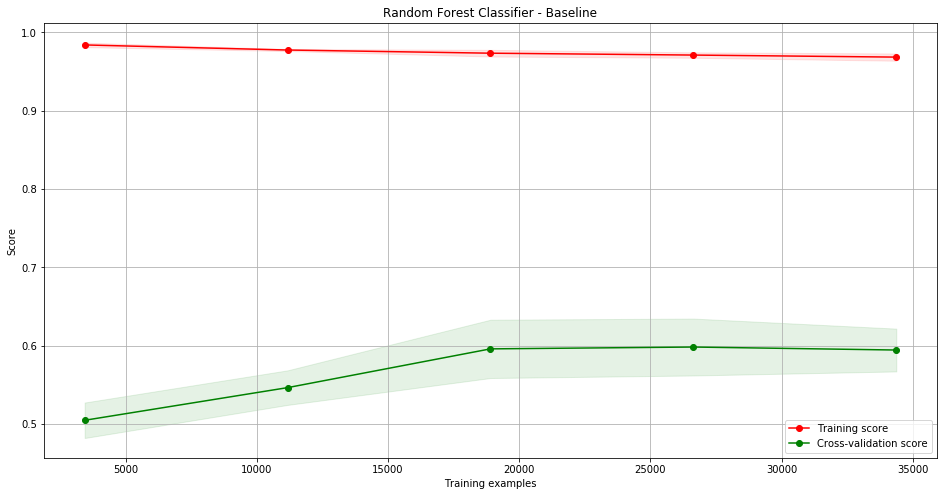

In [63]:
xgboost_baseline = base_models[1][1]
plot_learning_curve(xgboost_baseline, 
                        "Random Forest Classifier - Baseline", 
                        x_train, 
                        y_train)

/home/lexlabs/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


<module 'matplotlib.pyplot' from '/home/lexlabs/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

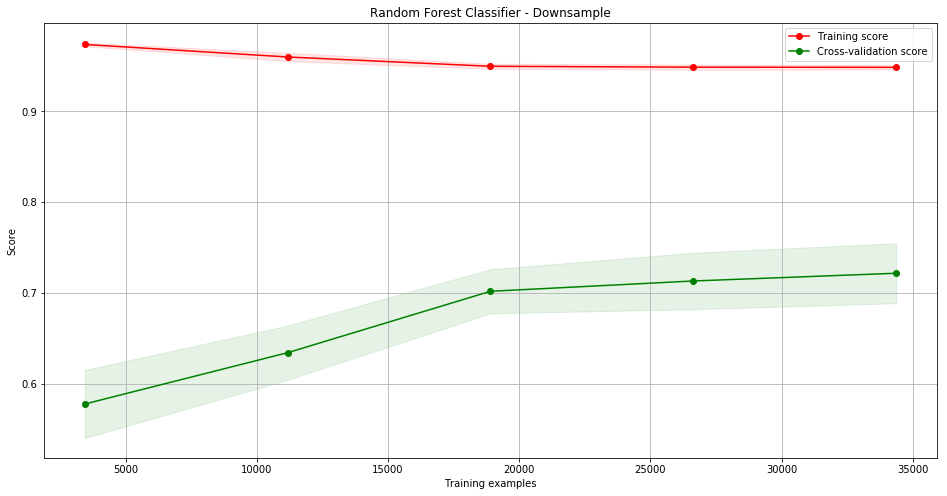

In [21]:
plot_learning_curve(rf_downsample.best_estimator_, 
                        "Random Forest Classifier - Downsample", 
                        x_train, 
                        y_train)

<module 'matplotlib.pyplot' from '/home/lexlabs/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

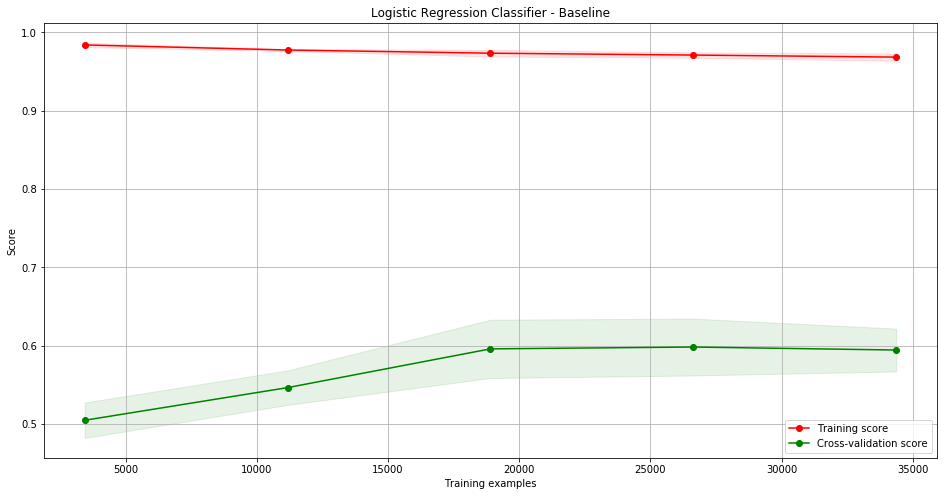

In [64]:
xgboost_baseline = base_models[1][1]
plot_learning_curve(xgboost_baseline, 
                        "Logistic Regression Classifier - Baseline", 
                        x_train, 
                        y_train)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [39]:
model = lr_grid
response = model.predict_proba(x_test)[:,1]

In [41]:
mailout_test["RESPONSE"] = response

mailout_test["RESPONSE"].to_csv("response.csv")

/home/lexlabs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
#importing kaggle scores
scores_kaggle = pd.read_csv("scores.csv",sep=";")

In [39]:
scores_kaggle

,model,Kaggle Score
0,Random Forest – DownSample,0.75527
1,Logistic Regression – DownSample,0.72105
2,XgBoost - DownSample,0.79744
3,Logistic Regression – BaseLine,0.67288
4,Random Forest – BaseLine,0.59498
5,XgBoost – BaseLine,0.79204
6,XgBoost,0.79593
7,Random Forest,0.75117
8,Logistic Regression,0.71897


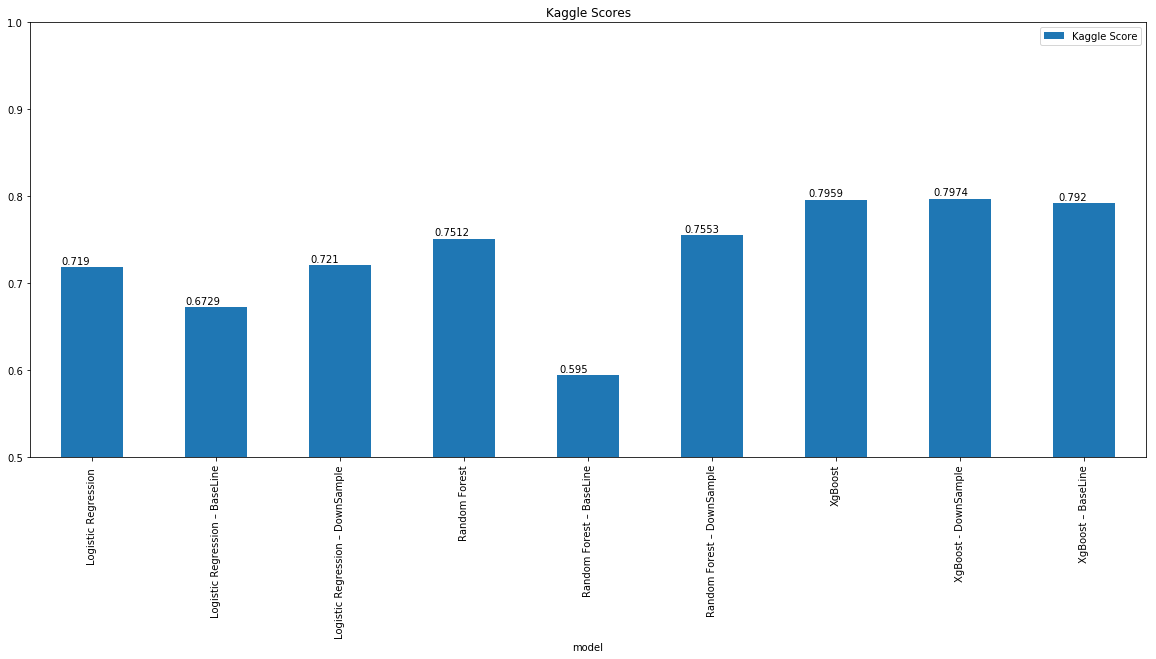

In [41]:
#plotting kaglle scores
ax = scores_kaggle.sort_values("model").set_index("model").plot(kind="bar",figsize=(20,8),ylim=[0.5,1.0],title="Kaggle Scores")
for p in ax.patches:
    ax.annotate(str(p.get_height().round(4)), (p.get_x() * 1.005, (p.get_height() * 1.005)))

### Features importances

In [128]:
#features importances
best_model = xgboost_grid_downsample.best_estimator_

feature_importances = best_model.feature_importances_

feature_importances = feature_importances / np.linalg.norm(feature_importances)

In [145]:
positions = []
for index,value in enumerate(feature_importances):
    if(value>=0.1):
        positions.append(index)


In [146]:
feature_importances[positions]

array([0.16528817, 0.11593883, 0.14332001, 0.20286669, 0.32013354,
       0.15256709, 0.11328186, 0.22877435, 0.10810513, 0.11830869,
       0.13849676], dtype=float32)

<BarContainer object of 11 artists>

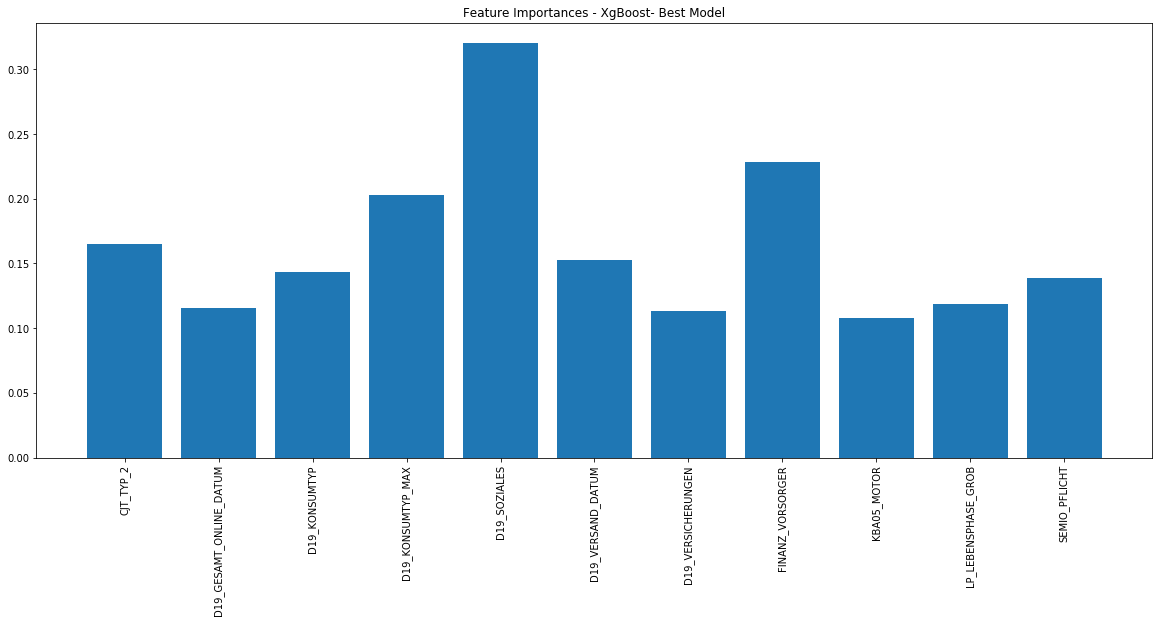

In [154]:
rcParams['figure.figsize'] = 20, 8

plt.xticks(rotation=90)
plt.title("Feature Importances - XgBoost- Best Model")

plt.bar(columns[positions],feature_importances[positions])